<a href="https://colab.research.google.com/github/Morsal-stack/EuropeanFunds/blob/main/Progetto_OpenCoesione_Regionale_Lazio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Indice** 

[I. Abstract sul portale OpenCoesione.](#scrollTo=3eCZqK4zmJ6w)

[II. Configurazione ambiente e caricamento delle librerie.](#scrollTo=oKkv9k0KmSRX)

[III. Importazione del file riguardante i metadati.](#scrollTo=AGR9kHJotTU9)

[IV. Fase di esplorazione del dataset riguardante la Regione Lazio per la Programmazione Comunitaria 2014-2020 attraverso Pandas.](#scrollTo=d-uWYlPjjhnP)

[V. Fase di cleaning del dataframe riguardante i progetti relativi alla Programmazione Comunitaria 2014-2020 attraverso la piattaforma SPARK.](#scrollTo=DzOVTu-YXEbu)

[VI. Fase di esplorazione del dataset riguardante la Regione Lazio per la Programmazione Comunitaria 2007-2013 attraverso Pandas.](#scrollTo=OBKKI5gL9ZIm)

[VII. Fase di cleaning del dataframe riguardante i progetti relativi alla Programmazione Comunitaria 2007 -2013 attraverso la piattaforma SPARK.](#scrollTo=oxC6Jk0wlsrm) 

[VIII. Analisi provinciale numerica e relativi grafici.](#scrollTo=qlezIwWX_FuC)

[VIII. Analisi provinciale di contesto e relativi grafici.](#scrollTo=xuw2bD_asDcJ)

[IX. Conclusioni ed osservazioni.](#scrollTo=Kepx5CZwwETs)



# **Abstract sul portale OpenCoesione.**

Per realizzare il presente progetto, si è posta l'attenzione sui Finanziamenti Comunitari disponibili sul portale Opencoesione al seguente link: https://opencoesione.gov.it

Nel citato portale, gestito dalla Ragioneria Generale dello Stato del Ministero dell’Economia e delle Finanze. è possibile trovare le informazioni sui progetti in attuazione della politica di coesione e dei fondi strutturali.


# **Configurazione ambiente e caricamento delle librerie**

Si è scelto di utilizzare Spark come piattaforma per l'elaborazione dei big data relativi ai finanziamenti comunitari. Per eseguire Spark in ambiente Google Colab, innanzitutto sono state installate tutte le dipendenze, quali Apache Spark 2.3.1 with hadoop 2.7 e Java 8 con Findspark. Quest'ultimo pacchetto, in particolare, è risultato utile per aggiungere PySpark al path di sistema in fase di esecuzione.
Successivamente si è avviata, pertanto, una sessione di Spark con la seguente configurazione:

spark = SparkSession.builder.master("local[*]").getOrCreate()
sqlContext = SQLContext(spark)

Inoltre si è usata la piattaforma Arrow come utility di ottimizzazione per convertire un dataframe PySpark in un dataframe pandas utilizzando il metodo toPandas() per convertire un dataframe PySpark in uno di tipo Pandas.
Tale metodo è utilizzabile impostando la seguente configurazione di Spark: 


```
# spark.sql.execution.arrow.enabled true
```



 


In [ ]:
!apt-get update

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz

!tar xf spark-2.3.1-bin-hadoop2.7.tgz

!pip install -q findspark

import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

!ls



import findspark

findspark.init()


Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [834 kB]
Hit:13 http://ppa.lau

In [ ]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
#from pyspark.sql import functions as F
from pyspark.sql.functions import when, col, isnull, count, isnan
from pyspark.sql.types import FloatType
spark = SparkSession.builder.master("local[*]").getOrCreate()
sqlContext = SQLContext(spark)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pp
import seaborn as sb
import plotly.express as pex
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
spark.conf.set("spark.sql.execution.arrow.enabled", "true")


# **Importazione del file riguardante i metadati.**

Nella sezione "Progetti", rintracciabile al link
https://opencoesione.gov.it/it/opendata/#!progetti_section, è possibile scaricare i dati riferiti a tutti i progetti in attuazione delle politiche di coesione del ciclo 2007-2013 e 2014-2020, finanziati con i Fondi Strutturali, il Fondo nazionale per lo Sviluppo e la Coesione (FSC) ed il Piano d’Azione per la Coesione (PAC). 

Dal portale si deduce che i dataset sono aggiornati bimestralmente e pubblicati a distanza di circa tre mesi dalla data di riferimento e che l’unità di rilevazione elemantare è il progetto, pertanto tutte le informazioni disponibili sono associate, direttamente o indirettamente ai progetti finanziati.

Pertanto si è iniziata la fase esplorativa importando su un dataframe il file denominato "metadati_progetti_tracciato_esteso.xls", scaricabile dalla sezione già citata. 

Una volta importato il file in un dataframe, si è proceduto ad escludere tutte le tabelle di origine che non fossero attinenti ai progetti.
Si è usata la funzione head(60) per visualizzare i primi 60 record del tracciato mentre la iloc per mostrare i restanti.


In [ ]:
Metadati = pd.read_excel (r'/content/drive/MyDrive/metadati_progetti_tracciato_esteso.xls')
Metadati.info()
MetadatiTabellaProgetti = Metadati.loc[Metadati['TABELLA DI ORIGINE'] == "PROGETTI"]
MetadatiTabellaProgetti.info()
MetadatiTabellaProgetti.head(60)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 10 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   SEZIONE                                                        177 non-null    object 
 1   VARIABILE                                                      177 non-null    object 
 2   DESCRIZIONE                                                    177 non-null    object 
 3   TIPO                                                           177 non-null    object 
 4   LUNGHEZZA                                                      85 non-null     float64
 5   VARIABILE PUBBLICATA DAL                                       177 non-null    int64  
 6   NOTE                                                           97 non-null     object 
 7   LINK                                                          

,SEZIONE,VARIABILE,DESCRIZIONE,TIPO,LUNGHEZZA,VARIABILE PUBBLICATA DAL,NOTE,LINK,TABELLA DI ORIGINE,CRITERI DI CREAZIONE DELLA VARIABILE DALLA TABELLA DI ORIGINE
0,Anagrafica,COD_LOCALE_PROGETTO,Codice chiave progetto,char,100.0,20111231,Codice identificativo univoco del progetto nel...,NaN,PROGETTI,NaN
1,Anagrafica,CUP,Codice Unico di Progetto,char,15.0,20111231,Codice Unico di Progetto (CUP): codice assegna...,http://www.programmazioneeconomica.gov.it/sist...,PROGETTI,NaN
2,Anagrafica,OC_TITOLO_PROGETTO,Titolo del progetto,char,300.0,20111231,Denominazione del progetto. Se la denominazion...,NaN,PROGETTI,NaN
3,Anagrafica,OC_SINTESI_PROGETTO,Descrizione di dettaglio del progetto,char,1300.0,20180430,Informazione assente per i progetti del ciclo ...,NaN,PROGETTI,NaN
4,Anagrafica,OC_LINK,Indirizzo del progetto sul portale OpenCoesione,char,200.0,20140831,URL della scheda progetto sul portale www.open...,NaN,PROGETTI,NaN
5,Programmazione,OC_COD_CICLO,Codice del ciclo di programmazione,num,NaN,20180430,Codice che indica il ciclo di programmazione a...,NaN,PROGETTI,NaN
6,Programmazione,OC_DESCR_CICLO,Descrizione del ciclo di programmazione,char,100.0,20180430,Descrizione del ciclo di programmazione a cui ...,NaN,PROGETTI,NaN
7,Programmazione,OC_COD_TEMA_SINTETICO,Codice del tema sintetico (Aggregazione dei te...,char,2.0,20140831,Si tratta di un'articolazione tematica sinteti...,www.opencoesione.gov.it/opendata/raccordo_temi...,PROGETTI,NaN
8,Programmazione,OC_TEMA_SINTETICO,Descrizione del tema sintetico (Aggregazione d...,char,255.0,20111231,NaN,NaN,PROGETTI,NaN
9,Programmazione,COD_GRANDE_PROGETTO,Codice identificativo del grande progetto,char,14.0,20121231,"In base alla definizione comunitaria i ""grandi...",http://ec.europa.eu/regional_policy/projects/m...,PROGETTI,NaN


In [ ]:
MetadatiTabellaProgetti.iloc[61:70]

,SEZIONE,VARIABILE,DESCRIZIONE,TIPO,LUNGHEZZA,VARIABILE PUBBLICATA DAL,NOTE,LINK,TABELLA DI ORIGINE,CRITERI DI CREAZIONE DELLA VARIABILE DALLA TABELLA DI ORIGINE
91,Tempi,OC_DATA_FINE_PROGETTO_PREVISTA,Data prevista di conclusione del progetto,num,NaN,20180430,Rappresenta la data ultima prevista di conclus...,NaN,PROGETTI,NaN
92,Tempi,OC_DATA_FINE_PROGETTO_EFFETTIVA,Data effettiva di conclusione del progetto,num,NaN,20180430,Rappresenta la data ultima di effettiva conclu...,NaN,PROGETTI,NaN
125,Avanzamento,OC_STATO_FINANZIARIO,Stato avanzamento finanziario,char,20.0,20150831,Stato dell'avanzamento finanziario del progett...,NaN,PROGETTI,NaN
126,Avanzamento,OC_STATO_PROGETTO,Stato avanzamento progetto,char,20.0,20150831,"Stato dell'avanzamento del progetto, basato su...",NaN,PROGETTI,NaN
172,Flag,OC_FLAG_REGIONE_UNICA,Indica che le localizzazioni del progetto sono...,num,NaN,20141031,Il flag indica se il progetto è localizzato in...,NaN,PROGETTI,NaN
173,Flag,OC_FLAG_VISUALIZZAZIONE,Indica se il progetto è incluso o escluso dall...,num,NaN,20161231,Il flag indica se il progetto è pubblicato sul...,NaN,PROGETTI,NaN
175,Aggiornamento,DATA_AGGIORNAMENTO,Data di aggiornamento del progetto,num,NaN,20111231,E' la data a cui si riferiscono le informazion...,NaN,PROGETTI,NaN
176,Focus,OC_FOCUS,Indica l'appartenenza ai focus di approfondimento,char,100.0,20180430,Indica tramite hashtag l'appartenenza del prog...,https://opencoesione.gov.it/it/opendata/#appro...,PROGETTI,NaN


Da quanto appreso durante l'analisi del tracciato, si è ritenuto che le colonne di interesse fossero le seguenti:


- **COD_LOCALE_PROGETTO**: come riportato nel campo note del file metadati_progetti_tracciato_esteso, è il "Codice identificativo univoco del progetto nel sistema nazionale di monitoraggio e che funge da chiave di collegamento con gli altri dataset relativi ai progetti finanziati dalla politica di coesione (Localizzazioni, Soggetti, Pagamenti, Impegni, Fasi, Indicatori, Ambiti). Questo campo è stato assunto pertanto come la chiave primaria del suddetto elaborato;
- **OC_TEMA_SINTETICO**: è la descrizione del tema sintetico che ha un corrispettivo campo codificatore denominato 'OC_COD_TEMA_SINTETICO', che si è volutamente trascurato in quanto si sarebbe dovuta ricostruire una tabella di transcodifica;
- **OC_DESCR_CATEGORIA_SPESA**: descrizione della categoria di spesa;
- **CUP_DESCR_NATUR**: descrizione della natura del finanziamento;
- **CUP_DESCR_TIPOLOGIA**: descrizione della tipologia del progetto; 
- **DESCRIZIONE_GRANDE_PROGETTO** in base alla definizione comunitaria i "grandi progetti" sono generalmente progetti infrastrutturali su larga scala, grandi investimenti produttivi e progetti di ricerca e sviluppo, di costo superiore ai 50 milioni di euro, realizzati con il sostegno finanziario del Fondo Europeo di Sviluppo Regionale, per i quali è previsto uno specifico iter autorizzativo da parte della Commissione Europea.
- **COD_ATECO**: Codice identificativo della categoria economica del progetto;
- **DESCRIZIONE_ATECO**: descrizione della categoria economica del progetto(classificazione ATECO 2007);
- **FONDO_COMUNITARIO**: fondo comunitario di finanziamento del Programma Operativo finanziato dai Fondi Strutturali;
- **DEN_PROVINCIA**: denominazione della provincia;
- **FINANZ_TOTALE_PUBBLICO**: somma delle fonti di finanziamento pubbliche;

I seguenti campi:

*   OC_COD_CATEGORIA_SPESA
*   OC_COD_TEMA_SINTETICO
*   CUP_COD_NATURA
*   COD_PROVINCIA

contengono i codici identificativi dei rispettivi campi descrittivi. Si è deciso di scartarli in quanto non si conosce per ognuno di questi la relativa tabella di transcodifica.


# **Fase di esplorazione del dataset riguardante la Regione Lazio per la Programmazione Comunitaria 2014-2020 attraverso Pandas.**


La successiva fase è stata pertanto quella di esplorazione del dataset riguardante i progetti che riguardano la regione Lazio. Si è utilizzato Pandas per importare il file denominato "progetti_esteso_LAZ_2014-2020_20210430.csv" in un dataframe verificando che i dati, su cui sono incentrare l'analisi di questo elaborato, fossero effettivamente consistenti e fruibili per le successive elaborazioni.  

In [ ]:
PfProgetti1420 = pd.read_csv("/content/drive/MyDrive/progetti_esteso_LAZ_2014-2020_20210430.csv" , sep=';', low_memory=False)
PfProgetti1420.head(3)

,COD_LOCALE_PROGETTO,CUP,OC_TITOLO_PROGETTO,OC_SINTESI_PROGETTO,OC_LINK,OC_COD_CICLO,OC_DESCR_CICLO,OC_COD_TEMA_SINTETICO,OC_TEMA_SINTETICO,COD_GRANDE_PROGETTO,DESCRIZIONE_GRANDE_PROGETTO,OC_COD_FONTE,OC_DESCR_FONTE,FONDO_COMUNITARIO,OC_CODICE_PROGRAMMA,OC_DESCRIZIONE_PROGRAMMA,COD_OB_TEMATICO,DESCR_OB_TEMATICO,COD_PRIORITA_INVEST,DESCR_PRIORITA_INVEST,OC_COD_CATEGORIA_SPESA,OC_DESCR_CATEGORIA_SPESA,OC_ARTICOLAZIONE_PROGRAMMA,OC_SUBARTICOLAZIONE_PROGRAMMA,OC_COD_ARTICOLAZ_PROGRAMMA,OC_DESCR_ARTICOLAZ_PROGRAMMA,OC_COD_SUBARTICOLAZ_PROGRAMMA,OC_DESCR_SUBARTICOLAZ_PROGRAMMA,COD_STRUMENTO,DESCR_STRUMENTO,DESCR_TIPO_STRUMENTO,CUP_COD_NATURA,CUP_DESCR_NATURA,CUP_COD_TIPOLOGIA,CUP_DESCR_TIPOLOGIA,CUP_COD_SETTORE,CUP_DESCR_SETTORE,CUP_COD_SOTTOSETTORE,CUP_DESCR_SOTTOSETTORE,CUP_COD_CATEGORIA,...,OC_DENOM_ATTUATORE,OC_COD_FORMA_GIU_ATTUATORE,OC_DESCR_FORMA_GIU_ATTUATORE,OC_TOTALE_ATTUATORI,OC_CODFISC_BENEFICIARIO,OC_DENOM_BENEFICIARIO,OC_COD_FORMA_GIU_BENEFICIARIO,OC_DESCR_FORMA_GIU_BENEFICIARIO,OC_TOTALE_BENEFICIARI,OC_CODFISC_REALIZZATORE,OC_DENOM_REALIZZATORE,OC_COD_FORMA_GIU_REALIZZATORE,OC_DESCR_FORMA_GIU_REALIZZATORE,OC_TOTALE_REALIZZATORI,OC_TOTALE_INDICATORI,COD_INDICATORE_1,DESCR_INDICATORE_1,UNITA_MISURA_INDICATORE_1,PROGRAMMATO_INDICATORE_1,REALIZZATO_INDICATORE_1,COD_INDICATORE_2,DESCR_INDICATORE_2,UNITA_MISURA_INDICATORE_2,PROGRAMMATO_INDICATORE_2,REALIZZATO_INDICATORE_2,COD_INDICATORE_3,DESCR_INDICATORE_3,UNITA_MISURA_INDICATORE_3,PROGRAMMATO_INDICATORE_3,REALIZZATO_INDICATORE_3,COD_INDICATORE_4,DESCR_INDICATORE_4,UNITA_MISURA_INDICATORE_4,PROGRAMMATO_INDICATORE_4,REALIZZATO_INDICATORE_4,OC_FLAG_REGIONE_UNICA,OC_FLAG_VISUALIZZAZIONE,OC_FLAG_PAC,DATA_AGGIORNAMENTO,OC_FLAG_CUP
0,10SI10074,G15F15002810001,2014.IT.05.SFOP.014/1/8.1/7.3.2/7347 CANNIZZAR...,2014.IT.05.SFOP.014/1/8.1/7.3.2/7347 CANNIZZAR...,www.opencoesione.gov.it/progetti/10si10074,2,Ciclo di programmazione 2014-2020,8,Occupazione e mobilità dei lavoratori,,,FS1420,Fondi Strutturali relativi alla programmazione...,FSE,2014IT05SFOP014,POR FSE SICILIA,08,Promuovere un'occupazione sostenibile e di qua...,8ii,L'integrazione sostenibile nel mercato del lav...,103,Inserimento sostenibile dei giovani nel mercat...,ASSE,OBIETTIVO SPECIFICO,1,ASSE 1 - OCCUPAZIONE,8.1,Aumentare l'occupazione dei giovani,01,PROGRAMMA OPERATIVO 2014-2020,STRUMENTI ATTUAZIONE DIRETTA,6,CONCESSIONE DI CONTRIBUTI AD ALTRI SOGGETTI (D...,1,Acquisto servizi reali (inclusa formazione),11,"ISTRUZIONE, FORMAZIONE E SOSTEGNI PER IL MERCA...",72,ALTRI STRUMENTI FORMATIVI E DI WORK-EXPERIENCE,1,...,,,,NaN,80012000826,"DIPARTIMENTO REGIONALE DEL LAVORO, DELL'IMPIEG...",2.4.10,Regione,1,,,,,NaN,5,201F,"Disoccupati, compresi i disoccupati di lunga d...",Persone,10.0,1.0,201M,"Disoccupati, compresi i disoccupati di lunga d...",Persone,10.0,0.0,203F,Persone inattive (femmine),Persone,1.0,1.0,206F,Persone di eta' inferiore a 25 anni (femmine),Persone,10.0,1.0,NaN,0,0,20210331,NaN
1,10SI10644,F54I17000020006,"""INCENTIVO OCCUPAZIONE SUD"" DEL PROGRAMMA OPER...",PON SPAO,www.opencoesione.gov.it/progetti/10si10644,2,Ciclo di programmazione 2014-2020,8,Occupazione e mobilità dei lavoratori,,,FS1420,Fondi Strutturali relativi alla programmazione...,FSE,2014IT05SFOP014,POR FSE SICILIA,08,Promuovere un'occupazione sostenibile e di qua...,8i,L'accesso all'occupazione per le persone in ce...,102,Accesso all'occupazione per le persone in cerc...,ASSE,OBIETTIVO SPECIFICO,1,ASSE 1 - OCCUPAZIONE,8.5,Favorire l'inserimento lavorativo e l'occupazi...,01,PROGRAMMA OPERATIVO 2014-2020,STRUMENTI ATTUAZIONE DIRETTA,2,ACQUISTO O REALIZZAZIONE DI SERVIZI,99,Altro,11,"ISTRUZIONE, FORMAZIONE E SOSTEGNI PER IL MERCA...",75,CONTRIBUTI ED INCENTIVI AL LAVORO,820,...,*INDIVIDUO*:::05444190879:::04703940827:::*IND...,1.7.90:::1.7.90:::1.7.90:::1.7.90:::1.7.90:::1...,Altra forma di ente privato con personalitÃ Â ...,5057.0,06551740829:::06527250820:::06455990827:::0638...,06551740829:::06527250820:::06455990827:::0638...,1.7.90:::1.7.

Si è proceduto a verificare quanti campi NaN ci fossero, notando facilmente come il COD_ATECO non fosse mai asserito, escludendolo pertanto dalle fasi successive dell'analisi.
Si è trovata, invece, conferma del campo COD_LOCALE_PROGETTO ipotizzato come chiave primaria, in quanto i valori sono tutti differenti, al contrario dell'identificativo CUP che sarebbe stato l'unico altro campo candidabile a ricoprire il ruolo di chiave primaria.

In [ ]:
PfProgetti1420['COD_ATECO'].str.contains(" ").sum()



50861

In [ ]:
PfProgetti1420['COD_ATECO'].str.contains("").sum()

50861

In [ ]:
PfProgetti1420['COD_ATECO'].str.contains("  ").sum()

0

In [ ]:
PfProgetti1420['COD_ATECO'].unique()

array([' '], dtype=object)

In [ ]:
PfProgetti1420['COD_ATECO'].value_counts()

     50861
Name: COD_ATECO, dtype: int64

In [ ]:
PfProgetti1420['CUP'].unique()


array(['G15F15002810001', 'F54I17000020006', 'G71E15000470009', ...,
       'D25B19000650009', 'D95B19000890009', 'D95B19000900009'],
      dtype=object)

In [ ]:
PfProgetti1420['CUP'].value_counts()

F89J14004160007    15472
F89D16000740009       44
F84J18000870009       43
F21B17000640009       30
F59D16000230009       22
                   ...  
F26G14006570007        1
F86G14027350007        1
F46D14001050007        1
F66D14005720007        1
F66D14005800007        1
Name: CUP, Length: 34875, dtype: int64

In [ ]:
PfProgetti1420['COD_LOCALE_PROGETTO'].unique() 

array(['10SI10074', '10SI10644', '10SI11', ..., '9FRP1949332001G',
       '9FRP1972971001A', '9FRP1972971001G'], dtype=object)

In [ ]:
PfProgetti1420['COD_LOCALE_PROGETTO'].value_counts()

1ANPALLAZT0013687                1
1ANPALLAZT0015065                1
4LA17045AP000000129              1
1ANPALLAZT0005846                1
4MPI10.6.6A-FSEPON-LA-2017-42    1
                                ..
4LA16037AP000000089              1
4MPI10.2.2A-FSEPON-LA-2020-78    1
1ANPALLAZT0018410                1
1ANPALLAZT0004954                1
1ANPALLAZT0036266                1
Name: COD_LOCALE_PROGETTO, Length: 50861, dtype: int64

Una riflessione a parte ha meritato il campo denominato 'DEN_PROVINCIA', dove in alcuni record vi erano inserite nello stesso campo più province. Come si vedrà nel proseguo dell'elaborato, con la piattaforma SPARK si è proceduto pertanto a sostituire tutte le province coinvolte, alcune delle quali appartenenti a regioni diverse dal lazio, con quelle esclusivamente laziali. 
In particolare si può evincere, già da una preliminare analisi, come sia Roma la città più coinvolta nelle progettualità, ben 26345 volte su 50861 progetti mentre 26063 sul totale in via esclusiva, senza pertanto condividere progettualità con altre province. 




In [ ]:
PfProgetti1420['DEN_PROVINCIA'].unique() 

array(['ROMA:::PALERMO', 'ROMA', 'ROMA:::TRAPANI', 'ROMA:::RAGUSA',
       'ROMA:::MESSINA', 'ROMA:::NESSUNA LOCALIZZAZIONE', 'PISA:::ROMA',
       'ROMA:::AGRIGENTO', 'TORINO:::ROMA', 'ROMA:::CATANIA',
       'ROMA:::ENNA', 'AREZZO:::PERUGIA:::ROMA:::BARI',
       'PADOVA:::AREZZO:::PERUGIA:::ROMA', 'PERUGIA:::ROMA',
       'MODENA:::PERUGIA:::ROMA', 'MILANO:::PERUGIA:::TERNI:::ROMA',
       'PERUGIA:::MACERATA:::ROMA',
       'MILANO:::BOLOGNA:::PERUGIA:::TERNI:::ROMA',
       'PERUGIA:::TERNI:::ROMA', 'TERNI:::ROMA',
       'MILANO:::PERUGIA:::TERNI:::FROSINONE', 'FROSINONE', 'RIETI',
       'VITERBO', 'LATINA',
       'MASSA-CARRARA:::LUCCA:::PISTOIA:::FIRENZE:::LIVORNO:::PISA:::AREZZO:::SIENA:::GROSSETO:::PRATO:::ROMA',
       ':::ROMA',
       'PERUGIA:::PESARO E URBINO:::ANCONA:::ROMA:::CASERTA:::BARI',
       '::::::TERNI::::::ROMA:::LECCE',
       'TORINO:::TRENTO:::VENEZIA:::UDINE:::PORDENONE:::BOLOGNA:::ROMA',
       ':::BRESCIA:::LECCO:::MONZA E DELLA BRIANZA::::::ROMA:::NA

In [ ]:
PfProgetti1420['DEN_PROVINCIA'].value_counts()

ROMA                            26063
LATINA                           9590
FROSINONE                        9007
RIETI                            2751
VITERBO                          2734
                                ...  
ROMA:::L'AQUILA:::LECCE             1
FIRENZE:::ROMA:::CATANIA            1
MILANO:::ROMA:::COSENZA             1
PISA:::ROMA                         1
ROMA:::BARLETTA-ANDRIA-TRANI        1
Name: DEN_PROVINCIA, Length: 135, dtype: int64

In [ ]:
PfProgetti1420ROMA = PfProgetti1420['DEN_PROVINCIA'].str.contains("ROMA")
PfProgetti1420ROMA.value_counts()

PfProgetti1420ROMA.head(100)
PfProgetti1420ROMA.value_counts()


True     26345
False    24516
Name: DEN_PROVINCIA, dtype: int64

In [ ]:
PfProgetti1420ROMA = PfProgetti1420['DEN_PROVINCIA'].str.contains("ROMA")
PfProgetti1420ROMA.value_counts()

PfProgetti1420ROMA.head(100)
PfProgetti1420ROMA.value_counts()


True     26345
False    24516
Name: DEN_PROVINCIA, dtype: int64

Si sono esplorati i seguenti campi senza rilevare grandi criticità se non qualche carattere accentato che viene visualizzato erroneamente:
*   OC_TEMA_SINTETICO
*   OC_DESCR_CATEGORIA_SPESA
*   CUP_DESCR_NATURA
*   FONDO_COMUNITARIO










In [ ]:
PfProgetti1420['OC_TEMA_SINTETICO'].unique()

array(['Occupazione e mobilità dei lavoratori',
       'Rafforzamento capacità della PA', 'Istruzione',
       'Inclusione sociale', 'Trasporti e infrastrutture a rete',
       'Ricerca e innovazione', 'Agenda digitale',
       'Ambiente e prevenzione dei rischi',
       'Attrazione culturale, naturale e turistica',
       'Competitività per le imprese', 'Energia e efficienza energetica'],
      dtype=object)

In [ ]:
PfProgetti1420['OC_TEMA_SINTETICO'].value_counts()

Occupazione e mobilità dei lavoratori         40796
Istruzione                                     3837
Agenda digitale                                2334
Inclusione sociale                             1598
Competitività per le imprese                    864
Ricerca e innovazione                           425
Rafforzamento capacità della PA                 368
Ambiente e prevenzione dei rischi               232
Energia e efficienza energetica                 172
Trasporti e infrastrutture a rete               128
Attrazione culturale, naturale e turistica      107
Name: OC_TEMA_SINTETICO, dtype: int64

In [ ]:
PfProgetti1420['OC_DESCR_CATEGORIA_SPESA'].unique()

array(["Inserimento sostenibile dei giovani nel mercato del lavoro, in particolare di quelli disoccupati e non iscritti a corsi d'istruzione o di formazione, compresi i giovani a rischio di esclusione sociale",
       "Accesso all'occupazione per le persone in cerca di lavoro e le persone inattive, compresi i disoccupati di lunga durata e le persone distanti dal mercato del lavoro, anche attraverso iniziative locali",
       "Investimenti nella capacitÃ\xa0 istituzionale e nell'efficienza delle pubbliche amministrazioni e dei servizi pubblici a livello nazionale, regionale e locale al fine di promuovere le riforme, una miglio",
       "Miglioramento della qualitÃ\xa0 e dell'efficienza e dell'accessibilitÃ\xa0 all'istruzione terziaria e di livello equivalente al fine di aumentare la partecipazione e i livelli di istruzione, in particolare",
       'Inclusione attiva, anche al fine di promuovere le pari opportunitÃ\xa0, e partecipazione attiva, nonchÃ© migliore occupabilitÃ\xa0',
       

In [ ]:
PfProgetti1420['OC_DESCR_CATEGORIA_SPESA'].value_counts()

Inserimento sostenibile dei giovani nel mercato del lavoro, in particolare di quelli disoccupati e non iscritti a corsi d'istruzione o di formazione, compresi i giovani a rischio di esclusione sociale    36133
Accesso all'occupazione per le persone in cerca di lavoro e le persone inattive, compresi i disoccupati di lunga durata e le persone distanti dal mercato del lavoro, anche attraverso iniziative locali     3631
Riduzione e prevenzione dell'abbandono scolastico prematuro e promozione della paritÃ  di accesso a un'istruzione prescolare, primaria e secondaria di qualitÃ , inclusi i percorsi di apprendimento di      2093
Servizi e applicazioni di inclusione digitale, accessibilitÃ  digitale, apprendimento per via elettronica e istruzione online, alfabetizzazione digitale                                                     1661
Inclusione attiva, anche al fine di promuovere le pari opportunitÃ , e partecipazione attiva, nonchÃ© migliore occupabilitÃ                                     

In [ ]:
PfProgetti1420['CUP_DESCR_NATURA'].unique()

array(["CONCESSIONE DI CONTRIBUTI AD ALTRI SOGGETTI (DIVERSI DA UNITA' PRODUTTIVE)",
       'ACQUISTO O REALIZZAZIONE DI SERVIZI',
       "CONCESSIONE DI INCENTIVI AD UNITA' PRODUTTIVE",
       'ACQUISTO DI BENI',
       'REALIZZAZIONE DI LAVORI PUBBLICI (OPERE ED IMPIANTISTICA)',
       'SOTTOSCRIZIONE INIZIALE O AUMENTO DI CAPITALE SOCIALE (COMPRESI SPIN OFF), FONDI DI RISCHIO O DI GARANZIA'],
      dtype=object)

In [ ]:
PfProgetti1420['CUP_DESCR_NATURA'].value_counts()

CONCESSIONE DI CONTRIBUTI AD ALTRI SOGGETTI (DIVERSI DA UNITA' PRODUTTIVE)                                   35961
ACQUISTO O REALIZZAZIONE DI SERVIZI                                                                           6092
CONCESSIONE DI INCENTIVI AD UNITA' PRODUTTIVE                                                                 5595
ACQUISTO DI BENI                                                                                              2072
REALIZZAZIONE DI LAVORI PUBBLICI (OPERE ED IMPIANTISTICA)                                                     1135
SOTTOSCRIZIONE INIZIALE O AUMENTO DI CAPITALE SOCIALE (COMPRESI SPIN OFF), FONDI DI RISCHIO O DI GARANZIA        6
Name: CUP_DESCR_NATURA, dtype: int64

In [ ]:
PfProgetti1420['FONDO_COMUNITARIO'].value_counts()

IOG     35634
FSE     10008
FESR     4136
         1083
Name: FONDO_COMUNITARIO, dtype: int64

Il campo "DESCRIZIONE_GRANDE_PROGETTO" risulta non essere mai asserito, quindi è stato escluso dai successivi step dell'analisi.

In [ ]:
PfProgetti1420['DESCRIZIONE_GRANDE_PROGETTO'].value_counts() 

     50861
Name: DESCRIZIONE_GRANDE_PROGETTO, dtype: int64

# **Fase di cleaning del dataframe riguardante i progetti relativi alla Programmazione Comunitaria 2014-2020 attraverso la piattaforma SPARK.**

Si è proceduto ad importare il file, già esaminato con Pandas, in un dataframe di tipo Spark.

In [ ]:
SfProgetti1420=spark.read.csv("/content/drive/MyDrive/progetti_esteso_LAZ_2014-2020_20210430.csv", sep=";", header = "true")
SfProgetti1420.dtypes

[('COD_LOCALE_PROGETTO', 'string'),
 ('CUP', 'string'),
 ('OC_TITOLO_PROGETTO', 'string'),
 ('OC_SINTESI_PROGETTO', 'string'),
 ('OC_LINK', 'string'),
 ('OC_COD_CICLO', 'string'),
 ('OC_DESCR_CICLO', 'string'),
 ('OC_COD_TEMA_SINTETICO', 'string'),
 ('OC_TEMA_SINTETICO', 'string'),
 ('COD_GRANDE_PROGETTO', 'string'),
 ('DESCRIZIONE_GRANDE_PROGETTO', 'string'),
 ('OC_COD_FONTE', 'string'),
 ('OC_DESCR_FONTE', 'string'),
 ('FONDO_COMUNITARIO', 'string'),
 ('OC_CODICE_PROGRAMMA', 'string'),
 ('OC_DESCRIZIONE_PROGRAMMA', 'string'),
 ('COD_OB_TEMATICO', 'string'),
 ('DESCR_OB_TEMATICO', 'string'),
 ('COD_PRIORITA_INVEST', 'string'),
 ('DESCR_PRIORITA_INVEST', 'string'),
 ('OC_COD_CATEGORIA_SPESA', 'string'),
 ('OC_DESCR_CATEGORIA_SPESA', 'string'),
 ('OC_ARTICOLAZIONE_PROGRAMMA', 'string'),
 ('OC_SUBARTICOLAZIONE_PROGRAMMA', 'string'),
 ('OC_COD_ARTICOLAZ_PROGRAMMA', 'string'),
 ('OC_DESCR_ARTICOLAZ_PROGRAMMA', 'string'),
 ('OC_COD_SUBARTICOLAZ_PROGRAMMA', 'string'),
 ('OC_DESCR_SUBARTICOLA

**Il** successivo step ha visto l'eliminazione di tutte quelle colonne non utili ai fini dell'analisi.

In [ ]:
ColonneDaEliminare = [
 
 'OC_TITOLO_PROGETTO', 
 'OC_SINTESI_PROGETTO', 
 'OC_LINK', 
 'OC_COD_CICLO', 
 'OC_DESCR_CICLO', 
 'OC_COD_CATEGORIA_SPESA',
 'OC_COD_TEMA_SINTETICO',
 'CUP_COD_NATURA',
 'COD_PROVINCIA',
 'CUP_COD_TIPOLOGIA',
 'COD_GRANDE_PROGETTO', 
 'DESCRIZIONE_GRANDE_PROGETTO', 
 'OC_COD_FONTE', 
 'OC_DESCR_FONTE',
 'COD_REGIONE', 
 'DEN_REGIONE',
 'OC_CODICE_PROGRAMMA', 
 'OC_DESCRIZIONE_PROGRAMMA', 
 'COD_OB_TEMATICO', 
 'DESCR_OB_TEMATICO', 
 'COD_PRIORITA_INVEST', 
 'DESCR_PRIORITA_INVEST', 
 'COD_COMUNE',
 'DEN_COMUNE',
 'OC_ARTICOLAZIONE_PROGRAMMA', 
 'OC_SUBARTICOLAZIONE_PROGRAMMA', 
 'OC_COD_ARTICOLAZ_PROGRAMMA', 
 'OC_DESCR_ARTICOLAZ_PROGRAMMA', 
 'OC_COD_SUBARTICOLAZ_PROGRAMMA', 
 'OC_DESCR_SUBARTICOLAZ_PROGRAMMA', 
 'COD_STRUMENTO', 
 'DESCR_STRUMENTO', 
 'DESCR_TIPO_STRUMENTO', 
 
 'CUP_COD_SETTORE', 
 'CUP_DESCR_SETTORE', 
 'CUP_COD_SOTTOSETTORE', 
 'CUP_DESCR_SOTTOSETTORE', 
 'CUP_COD_CATEGORIA', 
 'CUP_DESCR_CATEGORIA', 
 'COD_ATECO', 
 'DESCRIZIONE_ATECO',
 'OC_COD_TIPO_AIUTO', 
 'OC_DESCR_TIPO_AIUTO', 
 
 'OC_COD_SLL', 
 'OC_DENOMINAZIONE_SLL', 
 'FINANZ_UE', 
 'FINANZ_UE_FESR', 
 'FINANZ_UE_FSE', 
 'FINANZ_UE_FEASR', 
 'FINANZ_UE_FEAMP', 
 'FINANZ_UE_IOG', 
 'FINANZ_STATO_FONDO_DI_ROTAZIONE', 
 'FINANZ_STATO_FSC', 
 'FINANZ_STATO_PAC', 
 'FINANZ_STATO_COMPLETAMENTI', 
 'FINANZ_STATO_ALTRI_PROVVEDIMENTI', 
 'FINANZ_REGIONE', 
 'FINANZ_PROVINCIA', 
 'FINANZ_COMUNE', 
 'FINANZ_RISORSE_LIBERATE', 
 'FINANZ_ALTRO_PUBBLICO', 
 'FINANZ_STATO_ESTERO', 
 'FINANZ_PRIVATO', 
 'FINANZ_DA_REPERIRE', 
 'ECONOMIE_TOTALI', 
 'ECONOMIE_TOTALI_PUBBLICHE', 
 'OC_FINANZ_UE_NETTO', 
 'OC_FINANZ_UE_FESR_NETTO', 
 'OC_FINANZ_UE_FSE_NETTO', 
 'OC_FINANZ_UE_FEASR_NETTO', 
 'OC_FINANZ_UE_FEAMP_NETTO', 
 'OC_FINANZ_UE_IOG_NETTO', 
 'OC_FINANZ_STATO_FONDO_ROT_NETTO', 
 'OC_FINANZ_STATO_FSC_NETTO', 
 'OC_FINANZ_STATO_PAC_NETTO', 
 'OC_FINANZ_STATO_COMPL_NETTO', 
 'OC_FINANZ_STATO_ALTRI_PROV_NETTO', 
 'OC_FINANZ_REGIONE_NETTO', 
 'OC_FINANZ_PROVINCIA_NETTO', 
 'OC_FINANZ_COMUNE_NETTO', 
 'OC_FINANZ_RISORSE_LIBERATE_NETTO', 
 'OC_FINANZ_ALTRO_PUBBLICO_NETTO', 
 'OC_FINANZ_STATO_ESTERO_NETTO', 
 'OC_FINANZ_PRIVATO_NETTO', 
 'OC_FINANZ_TOT_PUB_NETTO', 
 'OC_COSTO_COESIONE', 
 'IMPEGNI', 
 'OC_IMPEGNI_GIURID_VINCOLANTI', 
 'OC_IMPEGNI_TRASFERIMENTI', 
 'OC_IMPEGNI_COESIONE', 
 'TOT_PAGAMENTI', 
 'OC_TOT_PAGAMENTI_BENEFICIARI', 
 'OC_TOT_PAGAMENTI_TRASFERIMENTI', 
 'COSTO_REALIZZATO', 
 'COSTO_RENDICONTABILE_UE', 
 'OC_TOT_PAGAMENTI_RENDICONTAB_UE', 
 'OC_TOT_PAGAMENTI_FSC', 
 'OC_TOT_PAGAMENTI_PAC', 
 'OC_PAGAMENTI_COESIONE', 
 'OC_DATA_INIZIO_PROGETTO', 
 'OC_DATA_FINE_PROGETTO_PREVISTA', 
 'OC_DATA_FINE_PROGETTO_EFFETTIVA', 
 'DATA_INIZIO_PREV_STUDIO_FATT', 
 'DATA_INIZIO_EFF_STUDIO_FATT', 
 'DATA_FINE_PREV_STUDIO_FATT', 
 'DATA_FINE_EFF_STUDIO_FATT', 
 'DATA_INIZIO_PREV_PROG_PREL', 
 'DATA_INIZIO_EFF_PROG_PREL', 
 'DATA_FINE_PREV_PROG_PREL', 
 'DATA_FINE_EFF_PROG_PREL', 
 'DATA_INIZIO_PREV_PROG_DEF', 
 'DATA_INIZIO_EFF_PROG_DEF', 
 'DATA_FINE_PREV_PROG_DEF', 
 'DATA_FINE_EFF_PROG_DEF', 
 'DATA_INIZIO_PREV_PROG_ESEC', 
 'DATA_INIZIO_EFF_PROG_ESEC', 
 'DATA_FINE_PREV_PROG_ESEC', 
 'DATA_FINE_EFF_PROG_ESEC', 
 'DATA_INIZIO_PREV_AGG_BANDO', 
 'DATA_INIZIO_EFF_AGG_BANDO', 
 'DATA_FINE_PREV_AGG_BANDO', 
 'DATA_FINE_EFF_AGG_BANDO', 
 'DATA_INIZIO_PREV_STIP_ATTRIB', 
 'DATA_INIZIO_EFF_STIP_ATTRIB', 
 'DATA_FINE_PREV_STIP_ATTRIB', 
 'DATA_FINE_EFF_STIP_ATTRIB', 
 'DATA_INIZIO_PREV_ESECUZIONE', 
 'DATA_INIZIO_EFF_ESECUZIONE', 
 'DATA_FINE_PREV_ESECUZIONE', 
 'DATA_FINE_EFF_ESECUZIONE', 
 'DATA_INIZIO_PREV_COLLAUDO', 
 'DATA_INIZIO_EFF_COLLAUDO', 
 'DATA_FINE_PREV_COLLAUDO', 
 'DATA_FINE_EFF_COLLAUDO', 
 'OC_STATO_FINANZIARIO', 
 'OC_STATO_PROGETTO', 
 'OC_STATO_PROCEDURALE', 
 'OC_COD_FASE_CORRENTE', 
 'OC_DESCR_FASE_CORRENTE', 
 'COD_PROCED_ATTIVAZIONE', 
 'DESCR_PROCED_ATTIVAZIONE', 
 'COD_TIPO_PROCED_ATTIVAZIONE', 
 'DESCR_TIPO_PROCED_ATTIVAZIONE', 
 'OC_CODFISC_PROGRAMMATORE', 
 'OC_DENOM_PROGRAMMATORE', 
 'OC_COD_FORMA_GIU_PROGRAMMATORE', 
 'OC_DESCR_FORMA_GIU_PROGRAMMATORE', 
 'OC_TOTALE_PROGRAMMATORI', 
 'OC_CODFISC_ATTUATORE', 
 'OC_DENOM_ATTUATORE', 
 'OC_COD_FORMA_GIU_ATTUATORE', 
 'OC_DESCR_FORMA_GIU_ATTUATORE', 
 'OC_TOTALE_ATTUATORI', 
 'OC_CODFISC_BENEFICIARIO', 
 'OC_DENOM_BENEFICIARIO', 
 'OC_COD_FORMA_GIU_BENEFICIARIO', 
 'OC_DESCR_FORMA_GIU_BENEFICIARIO', 
 'OC_TOTALE_BENEFICIARI', 
 'OC_CODFISC_REALIZZATORE', 
 'OC_DENOM_REALIZZATORE', 
 'OC_COD_FORMA_GIU_REALIZZATORE', 
 'OC_DESCR_FORMA_GIU_REALIZZATORE', 
 'OC_TOTALE_REALIZZATORI', 
 'OC_TOTALE_INDICATORI', 
 'COD_INDICATORE_1', 
 'DESCR_INDICATORE_1', 
 'UNITA_MISURA_INDICATORE_1', 
 'PROGRAMMATO_INDICATORE_1', 
 'REALIZZATO_INDICATORE_1', 
 'COD_INDICATORE_2', 
 'DESCR_INDICATORE_2', 
 'UNITA_MISURA_INDICATORE_2', 
 'PROGRAMMATO_INDICATORE_2', 
 'REALIZZATO_INDICATORE_2', 
 'COD_INDICATORE_3', 
 'DESCR_INDICATORE_3', 
 'UNITA_MISURA_INDICATORE_3', 
 'PROGRAMMATO_INDICATORE_3', 
 'REALIZZATO_INDICATORE_3', 
 'COD_INDICATORE_4', 
 'DESCR_INDICATORE_4', 
 'UNITA_MISURA_INDICATORE_4', 
 'PROGRAMMATO_INDICATORE_4', 
 'REALIZZATO_INDICATORE_4', 
 'OC_FLAG_REGIONE_UNICA', 
 'OC_FLAG_VISUALIZZAZIONE', 
 'OC_FLAG_PAC', 
 'DATA_AGGIORNAMENTO', 
 'OC_FLAG_CUP']
SfProgetti1420 = SfProgetti1420.drop(*ColonneDaEliminare)
SfProgetti1420.dtypes

[('COD_LOCALE_PROGETTO', 'string'),
 ('CUP', 'string'),
 ('OC_TEMA_SINTETICO', 'string'),
 ('FONDO_COMUNITARIO', 'string'),
 ('OC_DESCR_CATEGORIA_SPESA', 'string'),
 ('CUP_DESCR_NATURA', 'string'),
 ('CUP_DESCR_TIPOLOGIA', 'string'),
 ('DEN_PROVINCIA', 'string'),
 ('FINANZ_TOTALE_PUBBLICO', 'string')]

Si è pertanto proceduto attraverso la funzione when() a sostituire tutti i campi della colonna "DEN_PROVINCIA" che contenessero la stringa "ROMA"  (attraverso la funzione F.col('DEN_PROVINCIA').like('%ROMA%')) con la stringa "ROMA". 
Lo stesso algoritmo è stato utilizzato per le altre province e per quei campi che contenevano dati non conformi.

In [ ]:
from pyspark.sql import functions as F
SfProgetti1420 = SfProgetti1420.withColumn(
    'DEN_PROVINCIA',
    F.when(
        F.col('DEN_PROVINCIA').like('%ROMA%'),
        F.lit('ROMA')
    ).otherwise(F.col('DEN_PROVINCIA'))
)
SfProgetti1420 = SfProgetti1420.withColumn(
    'DEN_PROVINCIA',
    F.when(
        F.col('DEN_PROVINCIA').like('%RIETI%'),
        F.lit('RIETI')
    ).otherwise(F.col('DEN_PROVINCIA'))
)
SfProgetti1420 = SfProgetti1420.withColumn(
    'DEN_PROVINCIA',
    F.when(
        F.col('DEN_PROVINCIA').like('%FROSINONE%'),
        F.lit('FROSINONE')
    ).otherwise(F.col('DEN_PROVINCIA'))
)
SfProgetti1420 = SfProgetti1420.withColumn(
    'DEN_PROVINCIA',
    F.when(
        F.col('DEN_PROVINCIA').like('%LATINA%'),
        F.lit('LATINA')
    ).otherwise(F.col('DEN_PROVINCIA'))
)
SfProgetti1420 = SfProgetti1420.withColumn(
    'DEN_PROVINCIA',
    F.when(
        F.col('DEN_PROVINCIA').like('%VITERBO%'),
        F.lit('VITERBO')
    ).otherwise(F.col('DEN_PROVINCIA'))
)
SfProgetti1420 = SfProgetti1420.withColumn(
    'DEN_PROVINCIA',
    F.when(
        F.col('DEN_PROVINCIA').like('% %'),
        F.lit('')
    ).otherwise(F.col('DEN_PROVINCIA'))
)
SfProgetti1420 = SfProgetti1420.withColumn(
    'DEN_PROVINCIA',
    F.when(
        F.col('DEN_PROVINCIA').like('%:%'),
        F.lit('')
    ).otherwise(F.col('DEN_PROVINCIA'))
)
SfProgetti1420 = SfProgetti1420.withColumn(
    'DEN_PROVINCIA',
    F.when(
        F.col('DEN_PROVINCIA').like('012058'),
        F.lit('')
    ).otherwise(F.col('DEN_PROVINCIA'))
)

Si è verificato che l'operazione di cleaning fosse stata eseguita correttamente mostrando quanto segue in output.

In [ ]:
 SfProgetti1420.select("DEN_PROVINCIA").distinct().show()

+-------------+
|DEN_PROVINCIA|
+-------------+
|       LATINA|
|      VITERBO|
|        RIETI|
|         ROMA|
|    FROSINONE|
|             |
+-------------+



In [ ]:
 SfProgetti1420.groupBy('DEN_PROVINCIA').count().show()

+-------------+-----+
|DEN_PROVINCIA|count|
+-------------+-----+
|       LATINA| 9593|
|      VITERBO| 2736|
|        RIETI| 2754|
|         ROMA|26344|
|    FROSINONE| 9012|
|             |  422|
+-------------+-----+



Da come si evince dalla tabella precedente, sono rimasti 422 record non asseriti che si è proceduto ad eliminare attraverso la funzione filter.

In [ ]:
SfProgetti1420=SfProgetti1420.filter(SfProgetti1420.DEN_PROVINCIA != '')
SfProgetti1420Province = SfProgetti1420.groupBy('DEN_PROVINCIA').count()
SfProgetti1420Province.show()

+-------------+-----+
|DEN_PROVINCIA|count|
+-------------+-----+
|       LATINA| 9593|
|      VITERBO| 2736|
|        RIETI| 2754|
|         ROMA|26344|
|    FROSINONE| 9012|
+-------------+-----+



Il presupposto dell'analisi è che i dati da esplorare siano in qualche modo georefenziabili, procedendo all'esclusione di tutti quei progetti senza l'identificazione di una provincia laziale. 
Terminata la fase di cleaning, si è avviata quell'analitica con il supporto di alcuni grafici, convertendo il dataframe "ripulito" da uno di tipo SPARK ad uno di tipo PANDAS.

In [ ]:
PfProgetti1420Cleaned= SfProgetti1420.toPandas()


In [ ]:
PfProgetti1420Cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50439 entries, 0 to 50438
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   COD_LOCALE_PROGETTO       50439 non-null  object
 1   CUP                       50439 non-null  object
 2   OC_TEMA_SINTETICO         50439 non-null  object
 3   FONDO_COMUNITARIO         50439 non-null  object
 4   OC_DESCR_CATEGORIA_SPESA  50439 non-null  object
 5   CUP_DESCR_NATURA          50439 non-null  object
 6   CUP_DESCR_TIPOLOGIA       50439 non-null  object
 7   DEN_PROVINCIA             50439 non-null  object
 8   FINANZ_TOTALE_PUBBLICO    50439 non-null  object
dtypes: object(9)
memory usage: 3.5+ MB


# **Fase di esplorazione del dataset riguardante la Regione Lazio per la Programmazione Comunitaria 2007-2013 attraverso Pandas.**


Si sono effettuati gli stessi step per la fase di cleaning anche per il file contenente i progetti che interessano la regione del Lazio per la programmazione comunitaria 2007-2013, costatato che i campi risultano i medesimi.

In [ ]:
PfProgetti0713 = pd.read_csv("/content/drive/MyDrive/progetti_esteso_LAZ_2007-2013_20210430.csv" , sep=';', low_memory=False)
PfProgetti0713.head(3)

,COD_LOCALE_PROGETTO,CUP,OC_TITOLO_PROGETTO,OC_SINTESI_PROGETTO,OC_LINK,OC_COD_CICLO,OC_DESCR_CICLO,OC_COD_TEMA_SINTETICO,OC_TEMA_SINTETICO,COD_GRANDE_PROGETTO,DESCRIZIONE_GRANDE_PROGETTO,OC_COD_FONTE,OC_DESCR_FONTE,FONDO_COMUNITARIO,OC_CODICE_PROGRAMMA,OC_DESCRIZIONE_PROGRAMMA,COD_OB_TEMATICO,DESCR_OB_TEMATICO,COD_PRIORITA_INVEST,DESCR_PRIORITA_INVEST,OC_COD_CATEGORIA_SPESA,OC_DESCR_CATEGORIA_SPESA,OC_ARTICOLAZIONE_PROGRAMMA,OC_SUBARTICOLAZIONE_PROGRAMMA,OC_COD_ARTICOLAZ_PROGRAMMA,OC_DESCR_ARTICOLAZ_PROGRAMMA,OC_COD_SUBARTICOLAZ_PROGRAMMA,OC_DESCR_SUBARTICOLAZ_PROGRAMMA,COD_STRUMENTO,DESCR_STRUMENTO,DESCR_TIPO_STRUMENTO,CUP_COD_NATURA,CUP_DESCR_NATURA,CUP_COD_TIPOLOGIA,CUP_DESCR_TIPOLOGIA,CUP_COD_SETTORE,CUP_DESCR_SETTORE,CUP_COD_SOTTOSETTORE,CUP_DESCR_SOTTOSETTORE,CUP_COD_CATEGORIA,...,OC_DENOM_ATTUATORE,OC_COD_FORMA_GIU_ATTUATORE,OC_DESCR_FORMA_GIU_ATTUATORE,OC_TOTALE_ATTUATORI,OC_CODFISC_BENEFICIARIO,OC_DENOM_BENEFICIARIO,OC_COD_FORMA_GIU_BENEFICIARIO,OC_DESCR_FORMA_GIU_BENEFICIARIO,OC_TOTALE_BENEFICIARI,OC_CODFISC_REALIZZATORE,OC_DENOM_REALIZZATORE,OC_COD_FORMA_GIU_REALIZZATORE,OC_DESCR_FORMA_GIU_REALIZZATORE,OC_TOTALE_REALIZZATORI,OC_TOTALE_INDICATORI,COD_INDICATORE_1,DESCR_INDICATORE_1,UNITA_MISURA_INDICATORE_1,PROGRAMMATO_INDICATORE_1,REALIZZATO_INDICATORE_1,COD_INDICATORE_2,DESCR_INDICATORE_2,UNITA_MISURA_INDICATORE_2,PROGRAMMATO_INDICATORE_2,REALIZZATO_INDICATORE_2,COD_INDICATORE_3,DESCR_INDICATORE_3,UNITA_MISURA_INDICATORE_3,PROGRAMMATO_INDICATORE_3,REALIZZATO_INDICATORE_3,COD_INDICATORE_4,DESCR_INDICATORE_4,UNITA_MISURA_INDICATORE_4,PROGRAMMATO_INDICATORE_4,REALIZZATO_INDICATORE_4,OC_FLAG_REGIONE_UNICA,OC_FLAG_VISUALIZZAZIONE,OC_FLAG_PAC,DATA_AGGIORNAMENTO,OC_FLAG_CUP
0,17EMPG/2014/0098857,E86J13000590005,SOSTEGNO ALLO START-UP DI NUOVE IMPRESE INNOVA...,,www.opencoesione.gov.it/progetti/17empg2014009...,1,Ciclo di programmazione 2007-2013,1,Ricerca e innovazione,,,FS0713,Fondi Strutturali relativi alla programmazione...,FESR,2007IT162PO002,POR CRO FESR EMILIA ROMAGNA,,,,,09,"Altre misure per stimolare la ricerca, l'innov...",ASSE,OBIETTIVO SPECIFICO,01,Ricerca industriale e trasferimento tecnologico,002,Promuovere la nascita e lo sviluppo di nuove i...,,,,7,CONCESSIONE DI INCENTIVI AD UNITA' PRODUTTIVE,99,ALTRO,8,RICERCA SVILUPPO TECNOLOGICO ED INNOVAZIONE,62,PROGETTI DI RICERCA E DI INNOVAZIONE PRESSO I...,999,...,REGIONE EMILIA ROMAGNA,2.4.10,Regione,1.0,12497191002,POLYPRO SPA,1.3.10,"Società di fatto o irregolare, comunione ered...",1.0,,,,,NaN,NaN,,,,NaN,NaN,,,,NaN,NaN,,,,NaN,NaN,,,,NaN,NaN,1.0,0,0,20170430,1.0
1,17EMPG/2015/210797,E89J14004810005,SVILUPPO E INNOVAZIONE NEL SETTORE ICT PER CEL...,,www.opencoesione.gov.it/progetti/17empg2015210797,1,Ciclo di programmazione 2007-2013,2,Agenda digitale,,,FS0713,Fondi Strutturali relativi alla programmazione...,FESR,2007IT162PO002,POR CRO FESR EMILIA ROMAGNA,,,,,14,Servizi e applicazioni per le PMI (e-Commerc...,ASSE,OBIETTIVO SPECIFICO,02,Sviluppo innovativo delle imprese,001,Sostenere il potenziamento e la crescita delle...,,,,7,CONCESSIONE DI INCENTIVI AD UNITA' PRODUTTIVE,15,AMMODERNAMENTO,9,SERVIZI ALLE IMPRESE,21,SERVIZI ALLE IMPRESE INDUSTRIALI,212,...,REGIONE EMILIA ROMAGNA,2.4.10,Regione,1.0,03841590403,CELBO S.P.A.,1.3.10,"Società di fatto o irregolare, comunione ered...",1.0,,,,,NaN,NaN,,,,NaN,NaN,,,,NaN,NaN,,,,NaN,NaN,,,,NaN,NaN,1.0,0,0,20170430,1.0
2,17EMPG/2015/223908,E89J14004930005,INNOVARFE,,www.opencoesione.gov.it/progetti/17empg2015223908,1,Ciclo di programmazione 2007-2013,2,Agenda digitale,,,FS0713,Fondi Strutturali relativi alla programmazione...,FESR,2007IT162PO002,POR CRO FESR EMILIA ROMAGNA,,,,,14,Servizi e applicazioni per le PMI (e-Commerc...,ASSE,OBIETTIVO SPECIFICO,02,Sviluppo innovativo delle imprese,001,Sostenere il potenziamento e la crescita delle...,,,,7,CONCESSIONE DI INCENTIVI AD UNITA' PRODUTTIVE,15,AMMODERNAMENTO,9,SERVIZI ALLE IMPRESE,21,SERVIZI ALLE IMPRESE INDUSTRIALI,212,...,REGIONE EMILIA ROMAGNA,2.4.10,Regione,1.0,03354

In [ ]:
PfProgetti0713['OC_TEMA_SINTETICO'].value_counts()

Occupazione e mobilità dei lavoratori         6313
Istruzione                                    3083
Ricerca e innovazione                         1721
Inclusione sociale                            1069
Energia e efficienza energetica                462
Agenda digitale                                383
Competitività per le imprese                   291
Rafforzamento capacità della PA                250
Rinnovamento urbano  e rurale                  117
Attrazione culturale, naturale e turistica      97
Ambiente e prevenzione dei rischi               86
Trasporti e infrastrutture a rete               32
Name: OC_TEMA_SINTETICO, dtype: int64

In [ ]:
PfProgetti0713['OC_DESCR_CATEGORIA_SPESA'].unique()

array(["Altre misure per stimolare la ricerca, l'innovazione e l'imprenditorialità nelle PMI",
       'Servizi e applicazioni  per le PMI  (e-Commercio, istruzione e formazione, reti, ecc.)',
       "Sviluppo di potenziale umano nel settore della ricerca e dell'innovazione, in particolare mediante studi post-graduate",
       'Misure che incoraggiano un invecchiamento attivo e prolungano la vita di lavoro',
       'Attuazione di misure attive e preventive sul mercato del lavoro',
       "Vie verso l'integrazione e il rientro nel mondo del lavoro per le persone svantaggiate",
       "Sviluppo di servizi speciali per l'occupazione, la formazione e il sostegno connessi alla ristrutturazione settoriale",
       "Progettazione, introduzione e attuazione di riforme dei sistemi dell'istruzione e della formazione",
       "Misure per aumentare la partecipazione all'istruzione e alla formazione in tutto il ciclo di vita",
       "Misure per migliorare l'accesso all'occupazione e aumentare la pa

In [ ]:
PfProgetti0713['OC_DESCR_CATEGORIA_SPESA'].value_counts()

Misure per aumentare la partecipazione all'istruzione e alla formazione in tutto il ciclo di vita                         1918
Misure che incoraggiano un invecchiamento attivo e prolungano la vita di lavoro                                           1798
Attuazione di misure attive e preventive sul mercato del lavoro                                                           1570
Vie verso l'integrazione e il rientro nel mondo del lavoro per le persone svantaggiate                                    1061
Sviluppo di sistemi e strategie di apprendimento permanente nelle imprese; formazione e servizi per i dipendenti          1007
Altre misure per stimolare la ricerca, l'innovazione e l'imprenditorialità nelle PMI                                       789
Misure per migliorare l'accesso all'occupazione e aumentare la partecipazione sostenibile e il progresso delle donne       676
Assistenza alle PMI nella promozione di prodotti e processi di produzione ecologici (...)                      

In [ ]:
PfProgetti0713['CUP_DESCR_NATURA'].unique()

array(["CONCESSIONE DI INCENTIVI AD UNITA' PRODUTTIVE",
       "CONCESSIONE DI CONTRIBUTI AD ALTRI SOGGETTI (DIVERSI DA UNITA' PRODUTTIVE)",
       'ACQUISTO O REALIZZAZIONE DI SERVIZI', 'ACQUISTO DI BENI',
       'REALIZZAZIONE DI LAVORI PUBBLICI (OPERE ED IMPIANTISTICA)',
       'SOTTOSCRIZIONE INIZIALE O AUMENTO DI CAPITALE SOCIALE (COMPRESI SPIN OFF), FONDI DI RISCHIO O DI GARANZIA'],
      dtype=object)

In [ ]:
PfProgetti0713['CUP_DESCR_NATURA'].value_counts()

ACQUISTO O REALIZZAZIONE DI SERVIZI                                                                          7762
CONCESSIONE DI CONTRIBUTI AD ALTRI SOGGETTI (DIVERSI DA UNITA' PRODUTTIVE)                                   2782
CONCESSIONE DI INCENTIVI AD UNITA' PRODUTTIVE                                                                2597
REALIZZAZIONE DI LAVORI PUBBLICI (OPERE ED IMPIANTISTICA)                                                     732
ACQUISTO DI BENI                                                                                               24
SOTTOSCRIZIONE INIZIALE O AUMENTO DI CAPITALE SOCIALE (COMPRESI SPIN OFF), FONDI DI RISCHIO O DI GARANZIA       7
Name: CUP_DESCR_NATURA, dtype: int64

In [ ]:
PfProgetti0713['FONDO_COMUNITARIO'].value_counts()

FSE     11075
FESR     2632
          197
Name: FONDO_COMUNITARIO, dtype: int64

In [ ]:
PfProgetti0713['DEN_PROVINCIA'].value_counts()

ROMA                                                                                                                                                                                                                                                           9809
FROSINONE                                                                                                                                                                                                                                                      1419
LATINA                                                                                                                                                                                                                                                         1343
VITERBO                                                                                                                                                                                                                     

In [ ]:
PfProgetti0713ROMA = PfProgetti0713['DEN_PROVINCIA'].str.contains("ROMA")
PfProgetti0713ROMA.value_counts()

PfProgetti0713ROMA.head(100)
PfProgetti0713ROMA.value_counts()


True     9968
False    3936
Name: DEN_PROVINCIA, dtype: int64

# **Fase di cleaning del dataframe riguardante i progetti relativi alla Programmazione Comunitaria 2007 -2013 attraverso la piattaforma SPARK.**

Alla stregua di quanto sviluppato sul dataset relativo alla Programmazione Comunitaria 2014-2020, si è eseguita la fase di pulizia importando il file in un dataframe Spark.

In [ ]:
SfProgetti0713=spark.read.csv("/content/drive/MyDrive/progetti_esteso_LAZ_2007-2013_20210430.csv", sep=";", header = "true")

In [ ]:
SfProgetti0713.dtypes

[('COD_LOCALE_PROGETTO', 'string'),
 ('CUP', 'string'),
 ('OC_TITOLO_PROGETTO', 'string'),
 ('OC_SINTESI_PROGETTO', 'string'),
 ('OC_LINK', 'string'),
 ('OC_COD_CICLO', 'string'),
 ('OC_DESCR_CICLO', 'string'),
 ('OC_COD_TEMA_SINTETICO', 'string'),
 ('OC_TEMA_SINTETICO', 'string'),
 ('COD_GRANDE_PROGETTO', 'string'),
 ('DESCRIZIONE_GRANDE_PROGETTO', 'string'),
 ('OC_COD_FONTE', 'string'),
 ('OC_DESCR_FONTE', 'string'),
 ('FONDO_COMUNITARIO', 'string'),
 ('OC_CODICE_PROGRAMMA', 'string'),
 ('OC_DESCRIZIONE_PROGRAMMA', 'string'),
 ('COD_OB_TEMATICO', 'string'),
 ('DESCR_OB_TEMATICO', 'string'),
 ('COD_PRIORITA_INVEST', 'string'),
 ('DESCR_PRIORITA_INVEST', 'string'),
 ('OC_COD_CATEGORIA_SPESA', 'string'),
 ('OC_DESCR_CATEGORIA_SPESA', 'string'),
 ('OC_ARTICOLAZIONE_PROGRAMMA', 'string'),
 ('OC_SUBARTICOLAZIONE_PROGRAMMA', 'string'),
 ('OC_COD_ARTICOLAZ_PROGRAMMA', 'string'),
 ('OC_DESCR_ARTICOLAZ_PROGRAMMA', 'string'),
 ('OC_COD_SUBARTICOLAZ_PROGRAMMA', 'string'),
 ('OC_DESCR_SUBARTICOLA

In [ ]:
SfProgetti0713.schema

StructType(List(StructField(COD_LOCALE_PROGETTO,StringType,true),StructField(CUP,StringType,true),StructField(OC_TITOLO_PROGETTO,StringType,true),StructField(OC_SINTESI_PROGETTO,StringType,true),StructField(OC_LINK,StringType,true),StructField(OC_COD_CICLO,StringType,true),StructField(OC_DESCR_CICLO,StringType,true),StructField(OC_COD_TEMA_SINTETICO,StringType,true),StructField(OC_TEMA_SINTETICO,StringType,true),StructField(COD_GRANDE_PROGETTO,StringType,true),StructField(DESCRIZIONE_GRANDE_PROGETTO,StringType,true),StructField(OC_COD_FONTE,StringType,true),StructField(OC_DESCR_FONTE,StringType,true),StructField(FONDO_COMUNITARIO,StringType,true),StructField(OC_CODICE_PROGRAMMA,StringType,true),StructField(OC_DESCRIZIONE_PROGRAMMA,StringType,true),StructField(COD_OB_TEMATICO,StringType,true),StructField(DESCR_OB_TEMATICO,StringType,true),StructField(COD_PRIORITA_INVEST,StringType,true),StructField(DESCR_PRIORITA_INVEST,StringType,true),StructField(OC_COD_CATEGORIA_SPESA,StringType,true

In [ ]:
ColonneDaEliminare = [
 
 'OC_TITOLO_PROGETTO', 
 'OC_SINTESI_PROGETTO', 
 'OC_LINK', 
 'OC_COD_CICLO', 
 'OC_DESCR_CICLO', 
 'OC_COD_CATEGORIA_SPESA',
 'OC_COD_TEMA_SINTETICO',
 'CUP_COD_NATURA',
 'COD_PROVINCIA',
 'CUP_COD_TIPOLOGIA',
 'COD_GRANDE_PROGETTO', 
 'DESCRIZIONE_GRANDE_PROGETTO', 
 'OC_COD_FONTE', 
 'OC_DESCR_FONTE',
 'COD_REGIONE', 
 'DEN_REGIONE',
 'OC_CODICE_PROGRAMMA', 
 'OC_DESCRIZIONE_PROGRAMMA', 
 'COD_OB_TEMATICO', 
 'DESCR_OB_TEMATICO', 
 'COD_PRIORITA_INVEST', 
 'DESCR_PRIORITA_INVEST', 
 'COD_COMUNE',
 'DEN_COMUNE',
 'OC_ARTICOLAZIONE_PROGRAMMA', 
 'OC_SUBARTICOLAZIONE_PROGRAMMA', 
 'OC_COD_ARTICOLAZ_PROGRAMMA', 
 'OC_DESCR_ARTICOLAZ_PROGRAMMA', 
 'OC_COD_SUBARTICOLAZ_PROGRAMMA', 
 'OC_DESCR_SUBARTICOLAZ_PROGRAMMA', 
 'COD_STRUMENTO', 
 'DESCR_STRUMENTO', 
 'DESCR_TIPO_STRUMENTO', 
 
 'CUP_COD_SETTORE', 
 'CUP_DESCR_SETTORE', 
 'CUP_COD_SOTTOSETTORE', 
 'CUP_DESCR_SOTTOSETTORE', 
 'CUP_COD_CATEGORIA', 
 'CUP_DESCR_CATEGORIA', 
 'COD_ATECO', 
 'DESCRIZIONE_ATECO',
 'OC_COD_TIPO_AIUTO', 
 'OC_DESCR_TIPO_AIUTO', 
 
 'OC_COD_SLL', 
 'OC_DENOMINAZIONE_SLL', 
 'FINANZ_UE', 
 'FINANZ_UE_FESR', 
 'FINANZ_UE_FSE', 
 'FINANZ_UE_FEASR', 
 'FINANZ_UE_FEAMP', 
 'FINANZ_UE_IOG', 
 'FINANZ_STATO_FONDO_DI_ROTAZIONE', 
 'FINANZ_STATO_FSC', 
 'FINANZ_STATO_PAC', 
 'FINANZ_STATO_COMPLETAMENTI', 
 'FINANZ_STATO_ALTRI_PROVVEDIMENTI', 
 'FINANZ_REGIONE', 
 'FINANZ_PROVINCIA', 
 'FINANZ_COMUNE', 
 'FINANZ_RISORSE_LIBERATE', 
 'FINANZ_ALTRO_PUBBLICO', 
 'FINANZ_STATO_ESTERO', 
 'FINANZ_PRIVATO', 
 'FINANZ_DA_REPERIRE', 
 'ECONOMIE_TOTALI', 
 'ECONOMIE_TOTALI_PUBBLICHE', 
 'OC_FINANZ_UE_NETTO', 
 'OC_FINANZ_UE_FESR_NETTO', 
 'OC_FINANZ_UE_FSE_NETTO', 
 'OC_FINANZ_UE_FEASR_NETTO', 
 'OC_FINANZ_UE_FEAMP_NETTO', 
 'OC_FINANZ_UE_IOG_NETTO', 
 'OC_FINANZ_STATO_FONDO_ROT_NETTO', 
 'OC_FINANZ_STATO_FSC_NETTO', 
 'OC_FINANZ_STATO_PAC_NETTO', 
 'OC_FINANZ_STATO_COMPL_NETTO', 
 'OC_FINANZ_STATO_ALTRI_PROV_NETTO', 
 'OC_FINANZ_REGIONE_NETTO', 
 'OC_FINANZ_PROVINCIA_NETTO', 
 'OC_FINANZ_COMUNE_NETTO', 
 'OC_FINANZ_RISORSE_LIBERATE_NETTO', 
 'OC_FINANZ_ALTRO_PUBBLICO_NETTO', 
 'OC_FINANZ_STATO_ESTERO_NETTO', 
 'OC_FINANZ_PRIVATO_NETTO', 
 'OC_FINANZ_TOT_PUB_NETTO', 
 'OC_COSTO_COESIONE', 
 'IMPEGNI', 
 'OC_IMPEGNI_GIURID_VINCOLANTI', 
 'OC_IMPEGNI_TRASFERIMENTI', 
 'OC_IMPEGNI_COESIONE', 
 'TOT_PAGAMENTI', 
 'OC_TOT_PAGAMENTI_BENEFICIARI', 
 'OC_TOT_PAGAMENTI_TRASFERIMENTI', 
 'COSTO_REALIZZATO', 
 'COSTO_RENDICONTABILE_UE', 
 'OC_TOT_PAGAMENTI_RENDICONTAB_UE', 
 'OC_TOT_PAGAMENTI_FSC', 
 'OC_TOT_PAGAMENTI_PAC', 
 'OC_PAGAMENTI_COESIONE', 
 'OC_DATA_INIZIO_PROGETTO', 
 'OC_DATA_FINE_PROGETTO_PREVISTA', 
 'OC_DATA_FINE_PROGETTO_EFFETTIVA', 
 'DATA_INIZIO_PREV_STUDIO_FATT', 
 'DATA_INIZIO_EFF_STUDIO_FATT', 
 'DATA_FINE_PREV_STUDIO_FATT', 
 'DATA_FINE_EFF_STUDIO_FATT', 
 'DATA_INIZIO_PREV_PROG_PREL', 
 'DATA_INIZIO_EFF_PROG_PREL', 
 'DATA_FINE_PREV_PROG_PREL', 
 'DATA_FINE_EFF_PROG_PREL', 
 'DATA_INIZIO_PREV_PROG_DEF', 
 'DATA_INIZIO_EFF_PROG_DEF', 
 'DATA_FINE_PREV_PROG_DEF', 
 'DATA_FINE_EFF_PROG_DEF', 
 'DATA_INIZIO_PREV_PROG_ESEC', 
 'DATA_INIZIO_EFF_PROG_ESEC', 
 'DATA_FINE_PREV_PROG_ESEC', 
 'DATA_FINE_EFF_PROG_ESEC', 
 'DATA_INIZIO_PREV_AGG_BANDO', 
 'DATA_INIZIO_EFF_AGG_BANDO', 
 'DATA_FINE_PREV_AGG_BANDO', 
 'DATA_FINE_EFF_AGG_BANDO', 
 'DATA_INIZIO_PREV_STIP_ATTRIB', 
 'DATA_INIZIO_EFF_STIP_ATTRIB', 
 'DATA_FINE_PREV_STIP_ATTRIB', 
 'DATA_FINE_EFF_STIP_ATTRIB', 
 'DATA_INIZIO_PREV_ESECUZIONE', 
 'DATA_INIZIO_EFF_ESECUZIONE', 
 'DATA_FINE_PREV_ESECUZIONE', 
 'DATA_FINE_EFF_ESECUZIONE', 
 'DATA_INIZIO_PREV_COLLAUDO', 
 'DATA_INIZIO_EFF_COLLAUDO', 
 'DATA_FINE_PREV_COLLAUDO', 
 'DATA_FINE_EFF_COLLAUDO', 
 'OC_STATO_FINANZIARIO', 
 'OC_STATO_PROGETTO', 
 'OC_STATO_PROCEDURALE', 
 'OC_COD_FASE_CORRENTE', 
 'OC_DESCR_FASE_CORRENTE', 
 'COD_PROCED_ATTIVAZIONE', 
 'DESCR_PROCED_ATTIVAZIONE', 
 'COD_TIPO_PROCED_ATTIVAZIONE', 
 'DESCR_TIPO_PROCED_ATTIVAZIONE', 
 'OC_CODFISC_PROGRAMMATORE', 
 'OC_DENOM_PROGRAMMATORE', 
 'OC_COD_FORMA_GIU_PROGRAMMATORE', 
 'OC_DESCR_FORMA_GIU_PROGRAMMATORE', 
 'OC_TOTALE_PROGRAMMATORI', 
 'OC_CODFISC_ATTUATORE', 
 'OC_DENOM_ATTUATORE', 
 'OC_COD_FORMA_GIU_ATTUATORE', 
 'OC_DESCR_FORMA_GIU_ATTUATORE', 
 'OC_TOTALE_ATTUATORI', 
 'OC_CODFISC_BENEFICIARIO', 
 'OC_DENOM_BENEFICIARIO', 
 'OC_COD_FORMA_GIU_BENEFICIARIO', 
 'OC_DESCR_FORMA_GIU_BENEFICIARIO', 
 'OC_TOTALE_BENEFICIARI', 
 'OC_CODFISC_REALIZZATORE', 
 'OC_DENOM_REALIZZATORE', 
 'OC_COD_FORMA_GIU_REALIZZATORE', 
 'OC_DESCR_FORMA_GIU_REALIZZATORE', 
 'OC_TOTALE_REALIZZATORI', 
 'OC_TOTALE_INDICATORI', 
 'COD_INDICATORE_1', 
 'DESCR_INDICATORE_1', 
 'UNITA_MISURA_INDICATORE_1', 
 'PROGRAMMATO_INDICATORE_1', 
 'REALIZZATO_INDICATORE_1', 
 'COD_INDICATORE_2', 
 'DESCR_INDICATORE_2', 
 'UNITA_MISURA_INDICATORE_2', 
 'PROGRAMMATO_INDICATORE_2', 
 'REALIZZATO_INDICATORE_2', 
 'COD_INDICATORE_3', 
 'DESCR_INDICATORE_3', 
 'UNITA_MISURA_INDICATORE_3', 
 'PROGRAMMATO_INDICATORE_3', 
 'REALIZZATO_INDICATORE_3', 
 'COD_INDICATORE_4', 
 'DESCR_INDICATORE_4', 
 'UNITA_MISURA_INDICATORE_4', 
 'PROGRAMMATO_INDICATORE_4', 
 'REALIZZATO_INDICATORE_4', 
 'OC_FLAG_REGIONE_UNICA', 
 'OC_FLAG_VISUALIZZAZIONE', 
 'OC_FLAG_PAC', 
 'DATA_AGGIORNAMENTO', 
 'OC_FLAG_CUP']
SfProgetti0713 = SfProgetti0713.drop(*ColonneDaEliminare)
SfProgetti0713.dtypes

[('COD_LOCALE_PROGETTO', 'string'),
 ('CUP', 'string'),
 ('OC_TEMA_SINTETICO', 'string'),
 ('FONDO_COMUNITARIO', 'string'),
 ('OC_DESCR_CATEGORIA_SPESA', 'string'),
 ('CUP_DESCR_NATURA', 'string'),
 ('CUP_DESCR_TIPOLOGIA', 'string'),
 ('DEN_PROVINCIA', 'string'),
 ('FINANZ_TOTALE_PUBBLICO', 'string')]

In [ ]:
from pyspark.sql import functions as F
SfProgetti0713 = SfProgetti0713.withColumn(
    'DEN_PROVINCIA',
    F.when(
        F.col('DEN_PROVINCIA').like('%ROMA%'),
        F.lit('ROMA')
    ).otherwise(F.col('DEN_PROVINCIA'))
)
SfProgetti0713.show()

+-------------------+---------------+--------------------+-----------------+------------------------+--------------------+--------------------+-------------+----------------------+
|COD_LOCALE_PROGETTO|            CUP|   OC_TEMA_SINTETICO|FONDO_COMUNITARIO|OC_DESCR_CATEGORIA_SPESA|    CUP_DESCR_NATURA| CUP_DESCR_TIPOLOGIA|DEN_PROVINCIA|FINANZ_TOTALE_PUBBLICO|
+-------------------+---------------+--------------------+-----------------+------------------------+--------------------+--------------------+-------------+----------------------+
|17EMPG/2014/0098857|E86J13000590005|Ricerca e innovaz...|             FESR|    Altre misure per ...|CONCESSIONE DI IN...|               ALTRO|         ROMA|              49200,00|
| 17EMPG/2015/210797|E89J14004810005|     Agenda digitale|             FESR|    Servizi e applica...|CONCESSIONE DI IN...|      AMMODERNAMENTO|         ROMA|              20318,75|
| 17EMPG/2015/223908|E89J14004930005|     Agenda digitale|             FESR|    Servizi e appli

In [ ]:
from pyspark.sql import functions as F
SfProgetti0713 = SfProgetti0713.withColumn(
    'DEN_PROVINCIA',
    F.when(
        F.col('DEN_PROVINCIA').like('%ROMA%'),
        F.lit('ROMA')
    ).otherwise(F.col('DEN_PROVINCIA'))
)
SfProgetti0713 = SfProgetti0713.withColumn(
    'DEN_PROVINCIA',
    F.when(
        F.col('DEN_PROVINCIA').like('%RIETI%'),
        F.lit('RIETI')
    ).otherwise(F.col('DEN_PROVINCIA'))
)
SfProgetti0713 = SfProgetti0713.withColumn(
    'DEN_PROVINCIA',
    F.when(
        F.col('DEN_PROVINCIA').like('%FROSINONE%'),
        F.lit('FROSINONE')
    ).otherwise(F.col('DEN_PROVINCIA'))
)
SfProgetti0713 = SfProgetti0713.withColumn(
    'DEN_PROVINCIA',
    F.when(
        F.col('DEN_PROVINCIA').like('%LATINA%'),
        F.lit('LATINA')
    ).otherwise(F.col('DEN_PROVINCIA'))
)
SfProgetti0713 = SfProgetti0713.withColumn(
    'DEN_PROVINCIA',
    F.when(
        F.col('DEN_PROVINCIA').like('%VITERBO%'),
        F.lit('VITERBO')
    ).otherwise(F.col('DEN_PROVINCIA'))
)
SfProgetti0713 = SfProgetti0713.withColumn(
    'DEN_PROVINCIA',
    F.when(
        F.col('DEN_PROVINCIA').like('% %'),
        F.lit('')
    ).otherwise(F.col('DEN_PROVINCIA'))
)
SfProgetti0713 = SfProgetti0713.withColumn(
    'DEN_PROVINCIA',
    F.when(
        F.col('DEN_PROVINCIA').like('%:%'),
        F.lit('')
    ).otherwise(F.col('DEN_PROVINCIA'))
)
SfProgetti0713 = SfProgetti0713.withColumn(
    'DEN_PROVINCIA',
    F.when(
        F.col('DEN_PROVINCIA').like('%012058091%'),
        F.lit('')
    ).otherwise(F.col('DEN_PROVINCIA'))
)



In [ ]:
SfProgetti0713.select("DEN_PROVINCIA").distinct().show()

+-------------+
|DEN_PROVINCIA|
+-------------+
|       LATINA|
|      VITERBO|
|        RIETI|
|         ROMA|
|    FROSINONE|
|             |
+-------------+



In [ ]:
 SfProgetti0713.groupBy('DEN_PROVINCIA').count().show()

+-------------+-----+
|DEN_PROVINCIA|count|
+-------------+-----+
|       LATINA| 1345|
|      VITERBO|  665|
|        RIETI|  452|
|         ROMA| 9967|
|    FROSINONE| 1422|
|             |   53|
+-------------+-----+



In [ ]:
SfProgetti0713=SfProgetti0713.filter(SfProgetti0713.DEN_PROVINCIA != '')
SfProgetti0713Province = SfProgetti0713.groupBy('DEN_PROVINCIA').count()
SfProgetti0713Province.show()

+-------------+-----+
|DEN_PROVINCIA|count|
+-------------+-----+
|       LATINA| 1345|
|      VITERBO|  665|
|        RIETI|  452|
|         ROMA| 9967|
|    FROSINONE| 1422|
+-------------+-----+



In [ ]:
PfProgetti0713Cleaned= SfProgetti0713.toPandas()


In [ ]:
PfProgetti0713Cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13851 entries, 0 to 13850
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   COD_LOCALE_PROGETTO       13851 non-null  object
 1   CUP                       13851 non-null  object
 2   OC_TEMA_SINTETICO         13851 non-null  object
 3   FONDO_COMUNITARIO         13851 non-null  object
 4   OC_DESCR_CATEGORIA_SPESA  13851 non-null  object
 5   CUP_DESCR_NATURA          13851 non-null  object
 6   CUP_DESCR_TIPOLOGIA       13851 non-null  object
 7   DEN_PROVINCIA             13851 non-null  object
 8   FINANZ_TOTALE_PUBBLICO    13851 non-null  object
dtypes: object(9)
memory usage: 974.0+ KB


# **Analisi provinciale numerica e relativi grafici.**



Si è proceduto infine ad analizzare le due Programmazioni Comunitarie, partendo dalla distribuzione del numero dei progetti avviati dai soggetti beneficiari dei finanziamenti insistenti nelle province laziali.

Text(0, 0.5, 'Numero Progetti')

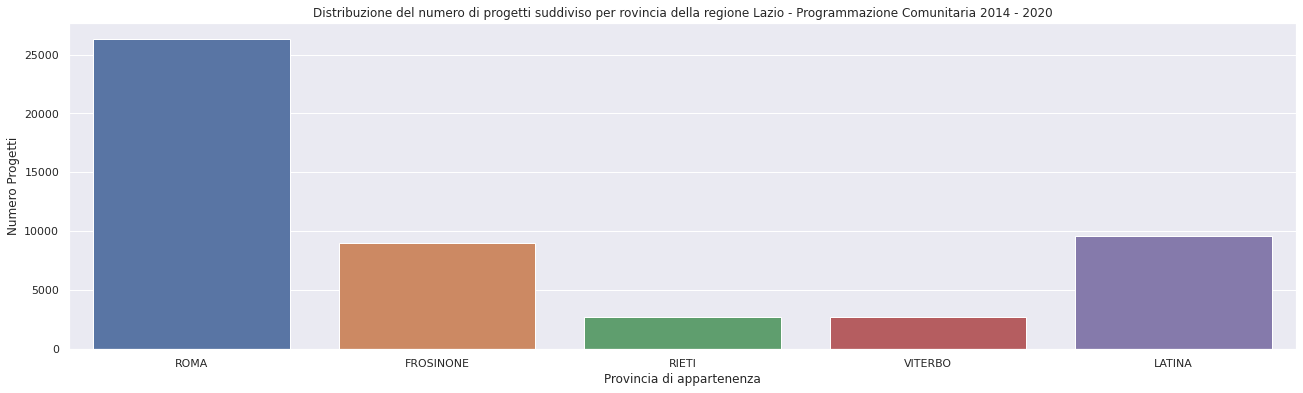

In [ ]:
sb.set(rc={'figure.figsize':(22,6)})
sb.countplot(x="DEN_PROVINCIA", data = PfProgetti1420Cleaned)
pp.title("Distribuzione del numero di progetti suddiviso per rovincia della regione Lazio - Programmazione Comunitaria 2014 - 2020")
pp.xlabel('Provincia di appartenenza')
pp.ylabel('Numero Progetti')

Text(0, 0.5, 'Numero Progetti')

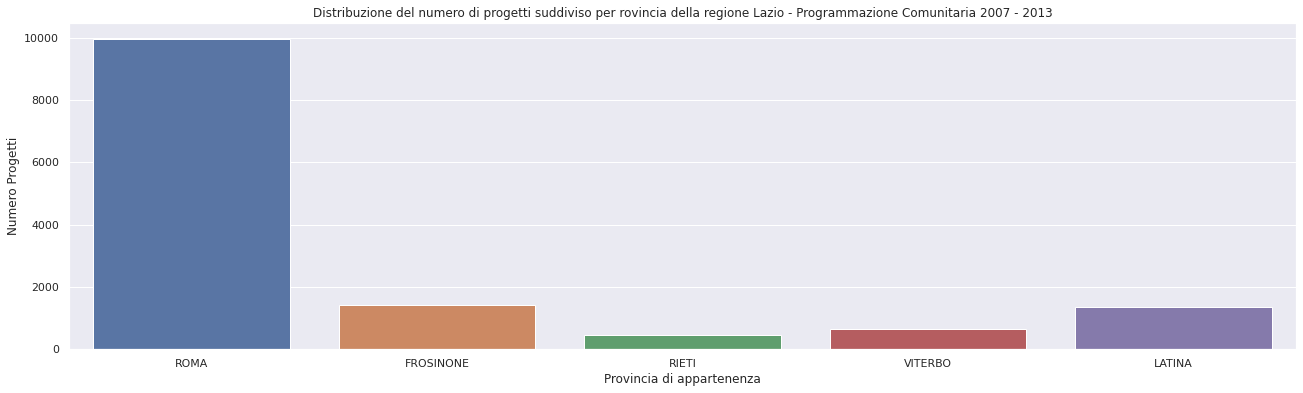

In [ ]:
sb.set(rc={'figure.figsize':(22,6)})
sb.countplot(x="DEN_PROVINCIA", data = PfProgetti0713Cleaned)
pp.title("Distribuzione del numero di progetti suddiviso per rovincia della regione Lazio - Programmazione Comunitaria 2007 - 2013")
pp.xlabel('Provincia di appartenenza')
pp.ylabel('Numero Progetti')

In [ ]:
PfProgetti1420Cleaned['FINANZ_TOTALE_PUBBLICO'] = PfProgetti1420Cleaned.FINANZ_TOTALE_PUBBLICO.str.replace(',', '.').astype(float)
PfProgetti1420Cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50439 entries, 0 to 50438
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   COD_LOCALE_PROGETTO       50439 non-null  object 
 1   CUP                       50439 non-null  object 
 2   OC_TEMA_SINTETICO         50439 non-null  object 
 3   FONDO_COMUNITARIO         50439 non-null  object 
 4   OC_DESCR_CATEGORIA_SPESA  50439 non-null  object 
 5   CUP_DESCR_NATURA          50439 non-null  object 
 6   CUP_DESCR_TIPOLOGIA       50439 non-null  object 
 7   DEN_PROVINCIA             50439 non-null  object 
 8   FINANZ_TOTALE_PUBBLICO    50439 non-null  float64
dtypes: float64(1), object(8)
memory usage: 3.5+ MB


In [ ]:
PfProgetti0713Cleaned['FINANZ_TOTALE_PUBBLICO'] = PfProgetti0713Cleaned.FINANZ_TOTALE_PUBBLICO.str.replace(',', '.').astype(float)
PfProgetti0713Cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13851 entries, 0 to 13850
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   COD_LOCALE_PROGETTO       13851 non-null  object 
 1   CUP                       13851 non-null  object 
 2   OC_TEMA_SINTETICO         13851 non-null  object 
 3   FONDO_COMUNITARIO         13851 non-null  object 
 4   OC_DESCR_CATEGORIA_SPESA  13851 non-null  object 
 5   CUP_DESCR_NATURA          13851 non-null  object 
 6   CUP_DESCR_TIPOLOGIA       13851 non-null  object 
 7   DEN_PROVINCIA             13851 non-null  object 
 8   FINANZ_TOTALE_PUBBLICO    13851 non-null  float64
dtypes: float64(1), object(8)
memory usage: 974.0+ KB


Da come si può evincere, Roma è la provincia avente il maggior numero di progetti finanziati attraverso la programmazione comunitaria 2014-2020. 
Con il seguente step si è voluto verificare se questa fosse anche la provincia avente il maggior importo dei finanziamenti che insistono per l'appunto sul territorio capitolino.
Pertanto si è convertito il campo FINANZ_TOTALE_PUBBLICO dal tipo object al tipo float grazie alla funzione astype, provvedendo a sostituire la virgola che delimita i decimali con il punto.
Il grafico successivo è stato realizzato con l'intento di mettere a confronto il numero dei progetti avviati e distribuiti per provincia, suddivisi per Programmazione Comunitaria.
Si evince come nella Programmazione 2014-2020 tutte le province abbiamo aumentato il numero dei progetti avviati e come Frosinone e Latina in particolare abbiano avuto l'incremento relativo maggiore, se confrontate con quanto svolto nella precedente programmazione.

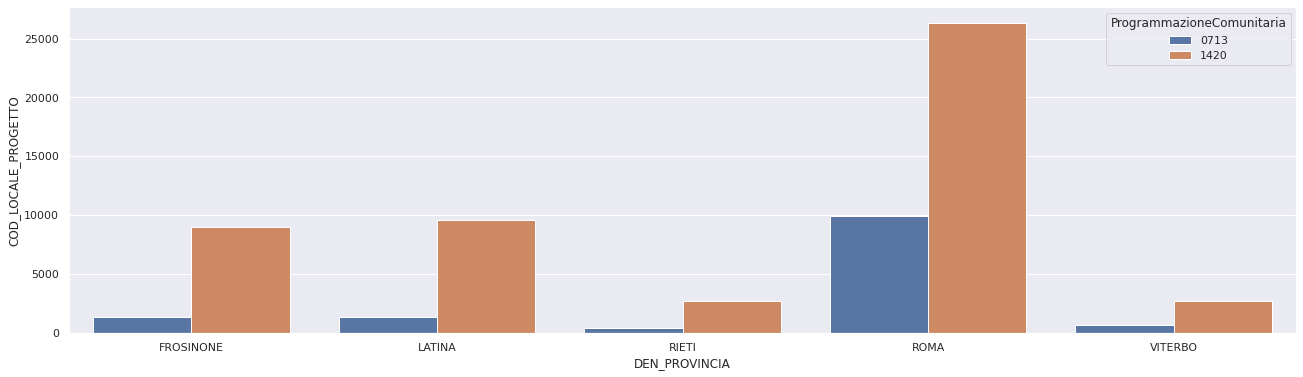

In [ ]:
PfProgetti1420TOTProgetti = PfProgetti1420Cleaned.drop(columns=['CUP',
 'OC_TEMA_SINTETICO',
 'FONDO_COMUNITARIO',
 'OC_DESCR_CATEGORIA_SPESA',
 'CUP_DESCR_NATURA',
 'CUP_DESCR_TIPOLOGIA',
 'FINANZ_TOTALE_PUBBLICO'])
PfProgetti1420TOTProgetti = PfProgetti1420TOTProgetti.groupby('DEN_PROVINCIA',as_index=False).count()
PfProgetti1420TOTProgetti.head(10)
PfProgetti0713TOTProgetti = PfProgetti0713Cleaned.drop(columns=['CUP',
 'OC_TEMA_SINTETICO',
 'FONDO_COMUNITARIO',
 'OC_DESCR_CATEGORIA_SPESA',
 'CUP_DESCR_NATURA',
 'CUP_DESCR_TIPOLOGIA',
 'FINANZ_TOTALE_PUBBLICO'])
PfProgetti0713TOTProgetti = PfProgetti0713TOTProgetti.groupby('DEN_PROVINCIA',as_index=False).count()

PfProgetti0713TOTProgetti.head(10)

anno0713 = pd.DataFrame({"DEN_PROVINCIA": ['FROSINONE','LATINA','RIETI','ROMA','VITERBO'], "ProgrammazioneComunitaria" : ['0713','0713','0713','0713','0713']})
anno0713.head(10)
anno1420 = pd.DataFrame({"DEN_PROVINCIA": ['FROSINONE','LATINA','RIETI','ROMA','VITERBO'],"ProgrammazioneComunitaria" : ['1420','1420','1420','1420','1420']})

ProgettiXProvincia0713TOTProgetti = pd.merge(PfProgetti0713TOTProgetti, anno0713 ,how='inner', on='DEN_PROVINCIA')
ProgettiXProvincia0713TOTProgetti.head(10)

ProgettiXProvincia1420TOTProgetti = pd.merge(PfProgetti1420TOTProgetti, anno1420 ,how='inner', on='DEN_PROVINCIA')
ProgettiXProvincia1420TOTProgetti.head(10)

ProgettiXProvinciaTOTProgetti = pd.concat([ProgettiXProvincia0713TOTProgetti,ProgettiXProvincia1420TOTProgetti],ignore_index=True) 
ProgettiXProvinciaTOTProgetti.head(15)

sb.barplot(x = "DEN_PROVINCIA", y = "COD_LOCALE_PROGETTO", hue="ProgrammazioneComunitaria", data = ProgettiXProvinciaTOTProgetti)



Nel grafico successivo si è voluto mettere a confronto il totale dell'importo finanziato e si è notato come Roma spicca in vetta anche per quanto riguarda quest'aspetto. Le province di Latina e Frosinone sebbene abbiamo aumentato notevolmente il numero di progetti avviati nella programmazione recente, non hanno seguito la stessa distribuzione per quanto riguarda gli importi.

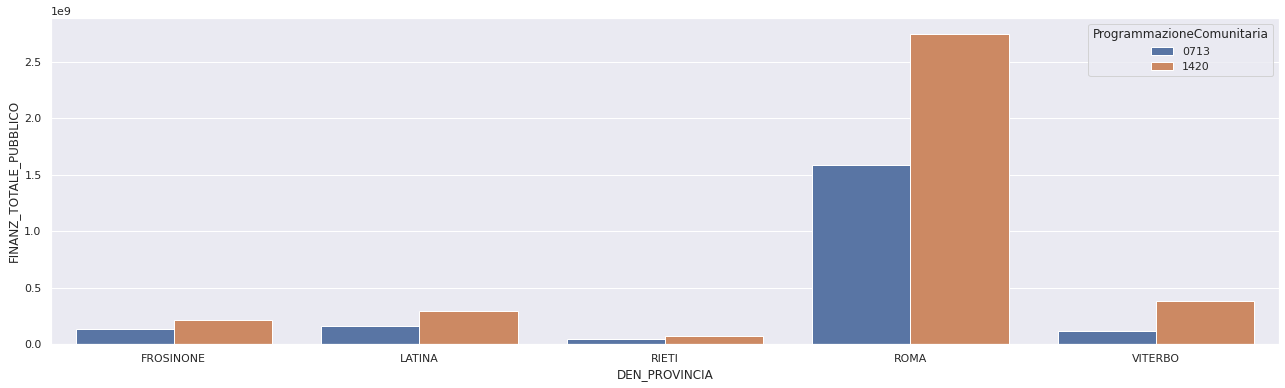

In [ ]:
PfProgetti1420TOTProgettiF = PfProgetti1420Cleaned.drop(columns=['CUP', 'COD_LOCALE_PROGETTO',
 'OC_TEMA_SINTETICO',
 'FONDO_COMUNITARIO',
 'OC_DESCR_CATEGORIA_SPESA',
 'CUP_DESCR_NATURA',
 'CUP_DESCR_TIPOLOGIA'
 ])
PfProgetti1420TOTProgettiF = PfProgetti1420TOTProgettiF.groupby('DEN_PROVINCIA',as_index=False).sum()
PfProgetti1420TOTProgettiF.head(10)
PfProgetti0713TOTProgettiF = PfProgetti0713Cleaned.drop(columns=['CUP', 'COD_LOCALE_PROGETTO',
 'OC_TEMA_SINTETICO',
 'FONDO_COMUNITARIO',
 'OC_DESCR_CATEGORIA_SPESA',
 'CUP_DESCR_NATURA',
 'CUP_DESCR_TIPOLOGIA'
 ])
PfProgetti0713TOTProgettiF = PfProgetti0713TOTProgettiF.groupby('DEN_PROVINCIA',as_index=False).sum()

PfProgetti0713TOTProgettiF.head(10)

anno0713 = pd.DataFrame({"DEN_PROVINCIA": ['FROSINONE','LATINA','RIETI','ROMA','VITERBO'], "ProgrammazioneComunitaria" : ['0713','0713','0713','0713','0713']})
anno0713.head(10)
anno1420 = pd.DataFrame({"DEN_PROVINCIA": ['FROSINONE','LATINA','RIETI','ROMA','VITERBO'],"ProgrammazioneComunitaria" : ['1420','1420','1420','1420','1420']})

ProgettiXProvincia0713TOTProgettiF = pd.merge(PfProgetti0713TOTProgettiF, anno0713 ,how='inner', on='DEN_PROVINCIA')
ProgettiXProvincia0713TOTProgettiF.head(10)

ProgettiXProvincia1420TOTProgettiF = pd.merge(PfProgetti1420TOTProgettiF, anno1420 ,how='inner', on='DEN_PROVINCIA')
ProgettiXProvincia1420TOTProgettiF.head(10)

ProgettiXProvinciaTOTF = pd.concat([ProgettiXProvincia0713TOTProgettiF,ProgettiXProvincia1420TOTProgettiF],ignore_index=True) 
ProgettiXProvinciaTOTF.head(15)

sb.barplot(x = "DEN_PROVINCIA", y = "FINANZ_TOTALE_PUBBLICO", hue="ProgrammazioneComunitaria", data = ProgettiXProvinciaTOTF)




Con il grafico successivo si è voluto correlare il numero di progetti svolti con gli importi distribuiti nelle varie Province. Per distinguere le province anche tra le due programmazioni si è deciso di inserire nel dataframe denominato "AnalisiProvinciale" la colonna "ChiavePr", che contiene la sigla della Provincia ed il codice 13 o 20 per identificare rispettivamente la passata o la recente programmazione.
Quello che emerge è come Roma sia anche qui fuori scala rispetto alle altre province laziali.

In [ ]:
AnalisiProvinciale = pd.merge(ProgettiXProvinciaTOTProgetti, ProgettiXProvinciaTOTF ,how='left', on=('DEN_PROVINCIA','ProgrammazioneComunitaria'))

ChiaveProvincia = pd.DataFrame(
{"ChiavePr" : ['FR13','LT13','RI13','RM13','VT13','FR20','LT20','RI20','RM20','VT20'],
"COD_LOCALE_PROGETTO" : [1422,1345,452,9967,665,9012,9593,2754,26344,2736]
}
)
AnalisiProvincialeSigle = pd.merge(AnalisiProvinciale,ChiaveProvincia, how='left', on='COD_LOCALE_PROGETTO')
AnalisiProvincialeSigle.head(10)

,DEN_PROVINCIA,COD_LOCALE_PROGETTO,ProgrammazioneComunitaria,FINANZ_TOTALE_PUBBLICO,ChiavePr
0,FROSINONE,1422,0713,1.365065e+08,FR13
1,LATINA,1345,0713,1.579303e+08,LT13
2,RIETI,452,0713,5.108807e+07,RI13
3,ROMA,9967,0713,1.583235e+09,RM13
4,VITERBO,665,0713,1.142022e+08,VT13
5,FROSINONE,9012,1420,2.178709e+08,FR20
6,LATINA,9593,1420,2.915920e+08,LT20
7,RIETI,2754,1420,7.699573e+07,RI20
8,ROMA,26344,1420,2.746045e+09,RM20
9,VITERBO,2736,1420,3.812340e+08,VT20


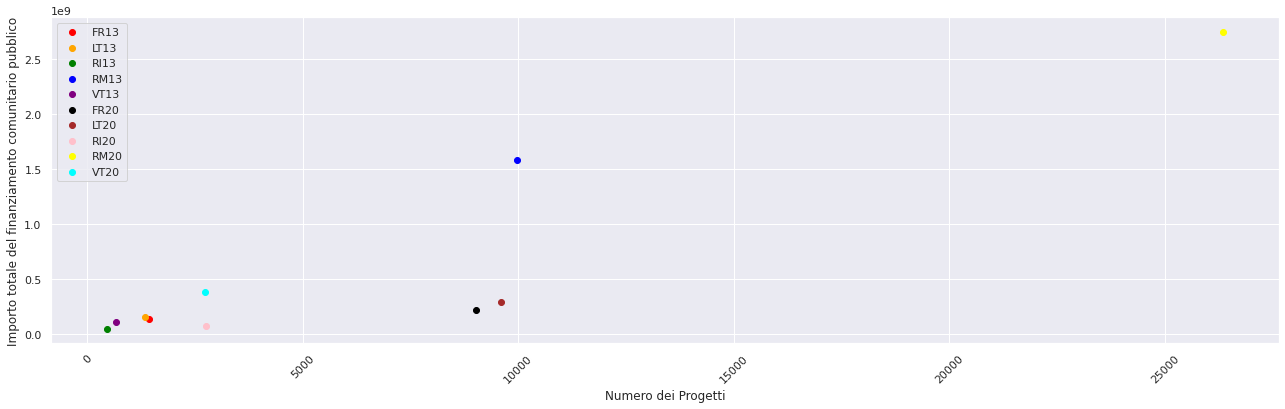

In [ ]:
colorlist = ['red','orange','green','blue','purple','black','brown','pink','yellow','cyan']

for (i, row) in enumerate(AnalisiProvincialeSigle.to_records('DEN_PROVINCIA')):
  pp.scatter(row['COD_LOCALE_PROGETTO'], row['FINANZ_TOTALE_PUBBLICO'], c=(colorlist[i] if i < 10 else 'lightgrey'), label=(row['ChiavePr'] if i < 10 else ''))

pp.legend()
pp.xticks(rotation=45)
pp.xlabel('Numero dei Progetti')
pp.ylabel('Importo totale del finanziamento comunitario pubblico')
pp.show()

Con il seguente grafico si è appreso come Roma, nonostante sia la provincia ad avere avviato più progetti e ad avere l'importo del totale del finanziamento pubblico più elevato non è la Provincia che ha l'importo medio del finanziamento in argomento per progetto più alto. 
Tale primato spetta infatti a Viterbo, per entrambe le programmazioni.
Si può notare inoltre come le distribuzioni medie seguano un andamento lineare per entrambe le programmazioni.

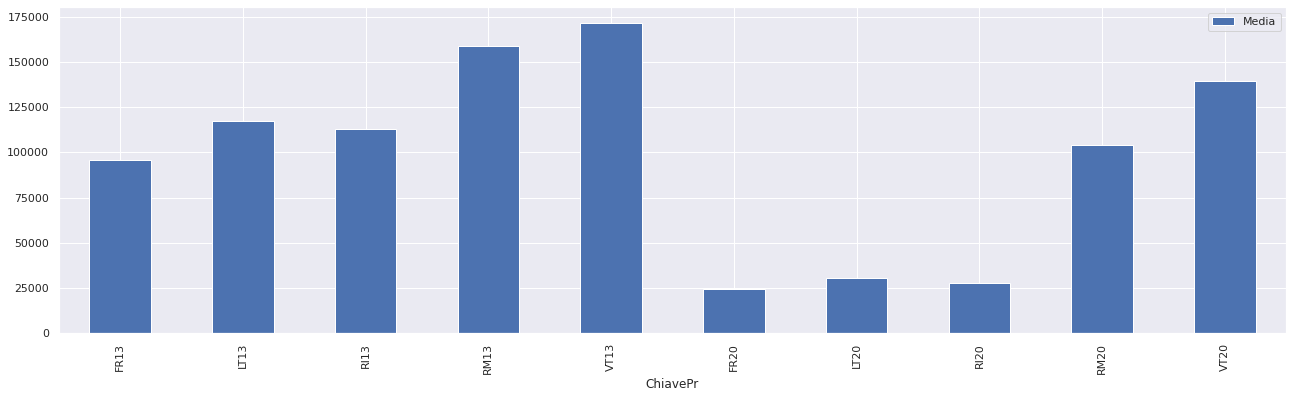

In [ ]:
Media = AnalisiProvincialeSigle['FINANZ_TOTALE_PUBBLICO']/AnalisiProvincialeSigle['COD_LOCALE_PROGETTO']
AnalisiProvincialeSigle['Media']= Media
AnalisiProvincialeSigle.head(10)
AnalisiProvincialeSigle.plot(kind='bar',x='ChiavePr',y='Media')

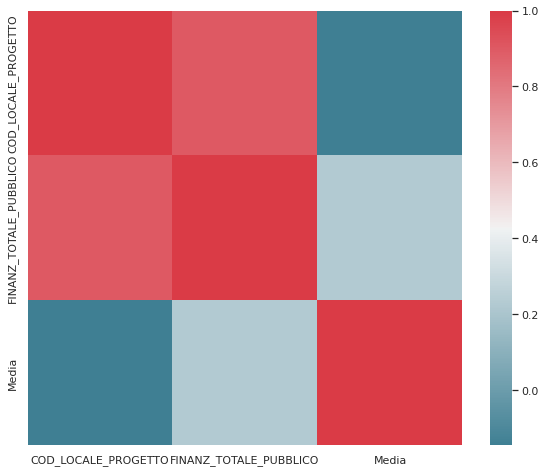

In [ ]:
f, ax = pp.subplots(figsize=(10, 8))
corr = AnalisiProvincialeSigle.corr()
sb.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sb.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


# **Analisi provinciale di contesto e relativi grafici.**

Nella seguente fase si è realizzata l'analisi di contesto. Da qui si può evincere su quali settori, o tematiche, siano stati distribuiti i finanziamenti. In particolare per ciò che concerne la natura del finanziamento si può notare come, per la programmazione Comunitaria 2014-2020, l'acquisto o la realizzazione di servizi, insieme alla realizzazione dei lavori pubblici (opere ed impiantistica), siano state più costose rispetto per esempio al mero acquisto di beni, è vi è da dire che questa  evidenza è inoltre una configurazione costante per le due programmazioni.

[Text(0, 0, 'ACQUISTO O REALIZZAZIONE DI SERVIZI'),
 Text(0, 0, 'REALIZZAZIONE DI LAVORI PUBBLICI (OPERE ED IMPIANTISTICA)'),
 Text(0, 0, "CONCESSIONE DI INCENTIVI AD UNITA' PRODUTTIVE"),
 Text(0, 0, 'ACQUISTO DI BENI'),
 Text(0, 0, "CONCESSIONE DI CONTRIBUTI AD ALTRI SOGGETTI (DIVERSI DA UNITA' PRODUTTIVE)")]

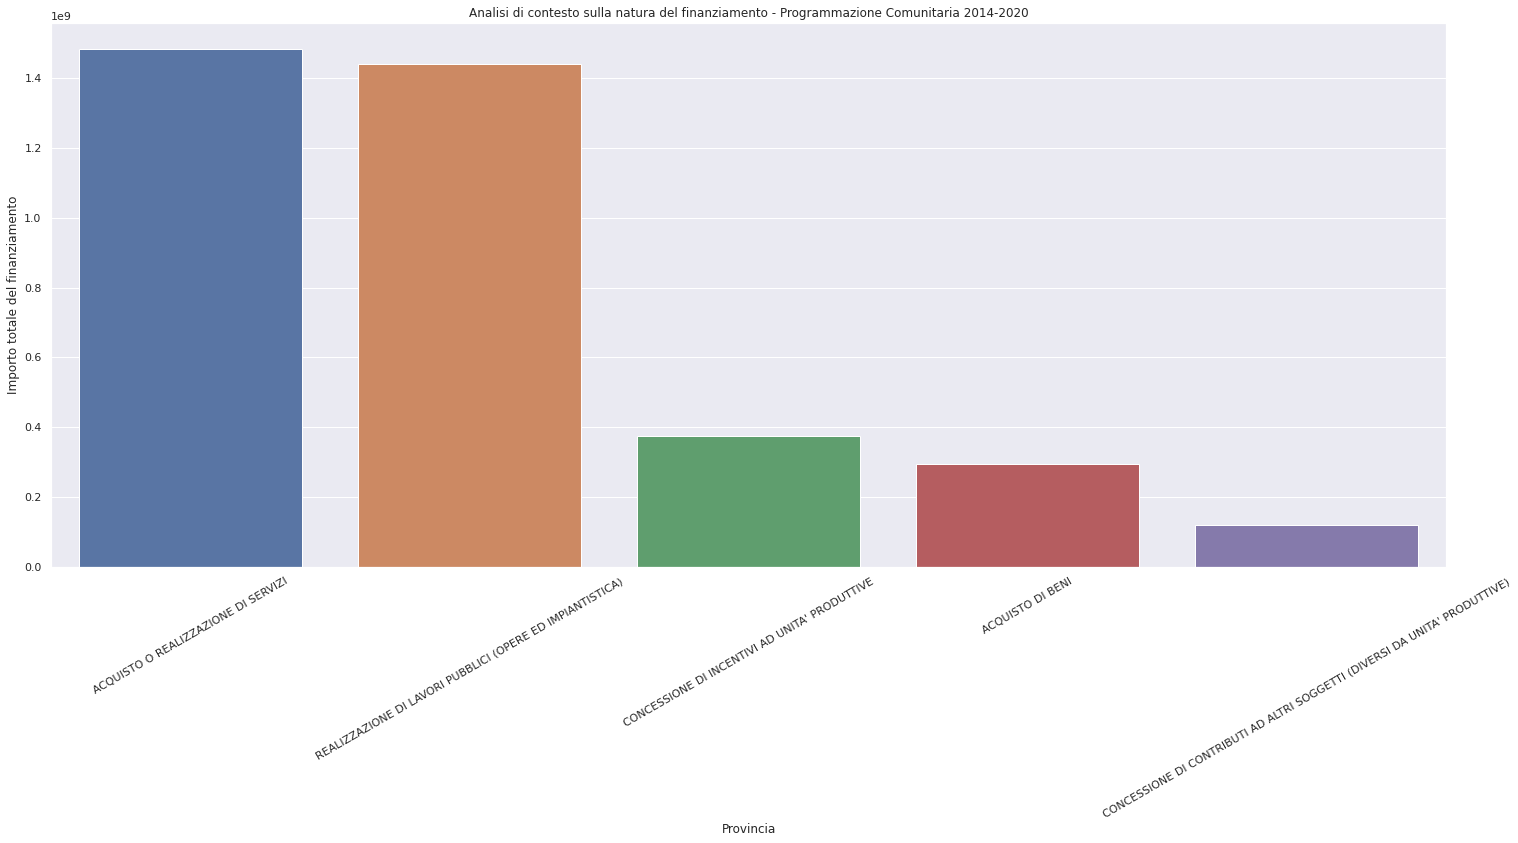

In [ ]:

PfProgetti1420CleanedDescrNatura=PfProgetti1420Cleaned.groupby('CUP_DESCR_NATURA', as_index=False).sum().sort_values('FINANZ_TOTALE_PUBBLICO',ascending=False)
PfProgetti1420CleanedDescrNatura.head(20)
sb.set(rc={'figure.figsize':(25,10)})
grafic=sb.barplot(data=PfProgetti1420CleanedDescrNatura,x='CUP_DESCR_NATURA',y='FINANZ_TOTALE_PUBBLICO', ci=False)
pp.title("Analisi di contesto sulla natura del finanziamento - Programmazione Comunitaria 2014-2020")
pp.xlabel('Natura del finanziamento')
pp.ylabel('Importo totale del finanziamento')
grafic.set_xticklabels(grafic.get_xticklabels(),rotation=30)




[Text(0, 0, 'ACQUISTO O REALIZZAZIONE DI SERVIZI'),
 Text(0, 0, 'REALIZZAZIONE DI LAVORI PUBBLICI (OPERE ED IMPIANTISTICA)'),
 Text(0, 0, "CONCESSIONE DI INCENTIVI AD UNITA' PRODUTTIVE"),
 Text(0, 0, "CONCESSIONE DI CONTRIBUTI AD ALTRI SOGGETTI (DIVERSI DA UNITA' PRODUTTIVE)"),
 Text(0, 0, 'ACQUISTO DI BENI')]

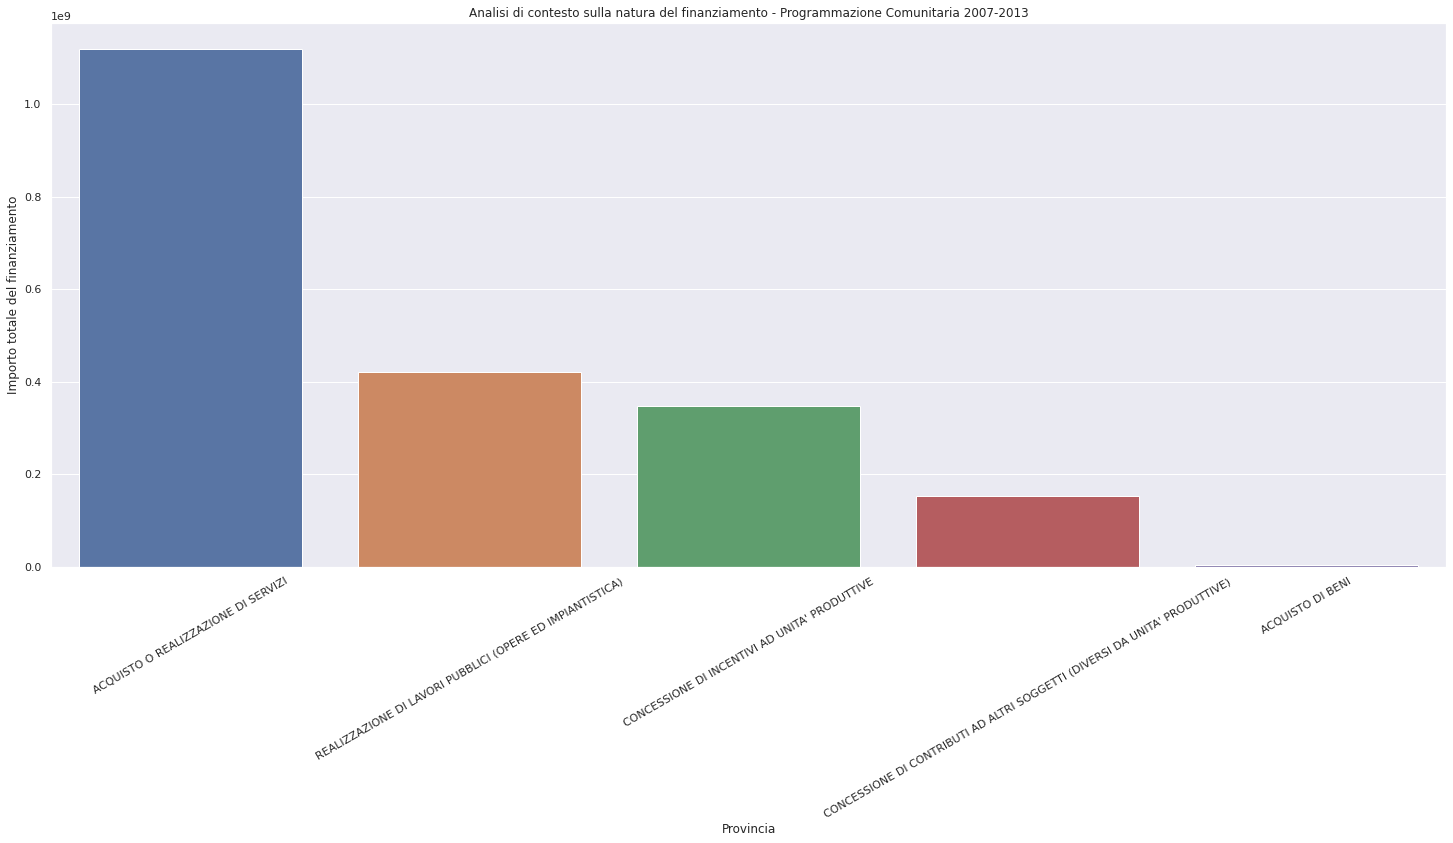

In [ ]:

PfProgetti0713CleanedDescrNatura=PfProgetti0713Cleaned.groupby('CUP_DESCR_NATURA', as_index=False).sum().sort_values('FINANZ_TOTALE_PUBBLICO',ascending=False)
PfProgetti0713CleanedDescrNatura.head(20)
sb.set(rc={'figure.figsize':(25,10)})
grafic=sb.barplot(data=PfProgetti0713CleanedDescrNatura,x='CUP_DESCR_NATURA',y='FINANZ_TOTALE_PUBBLICO', ci=False)
pp.title("Analisi di contesto sulla natura del finanziamento - Programmazione Comunitaria 2007-2013")
pp.xlabel('Natura del finanziamento')
pp.ylabel('Importo totale del finanziamento')
grafic.set_xticklabels(grafic.get_xticklabels(),rotation=30)




Per ciò che concerne il "tema" del finanziamento, questo verteva più sull'occupazione dei lavoratori e sulla formazione di questi rispetto alla programmazione più recente dove si è invece investito enormemente nei trasporti e nelle infrastrutture. Questo è comprensibile in quanto nel periodo 2007-2013 il Paese veniva fuori dalla recessione e vi era una maggiore attenzione a risolvere le criticità dovute alla scarsa occupazione piuttosto che ad investire su altri asset strategici.

[Text(0, 0, 'Trasporti e infrastrutture a rete'),
 Text(0, 0, 'Ricerca e innovazione'),
 Text(0, 0, 'Istruzione'),
 Text(0, 0, 'Occupazione e mobilità dei lavoratori'),
 Text(0, 0, 'Ambiente e prevenzione dei rischi'),
 Text(0, 0, 'Rafforzamento capacità della PA'),
 Text(0, 0, 'Attrazione culturale, naturale e turistica'),
 Text(0, 0, 'Inclusione sociale'),
 Text(0, 0, 'Agenda digitale'),
 Text(0, 0, 'Competitività per le imprese'),
 Text(0, 0, 'Energia e efficienza energetica')]

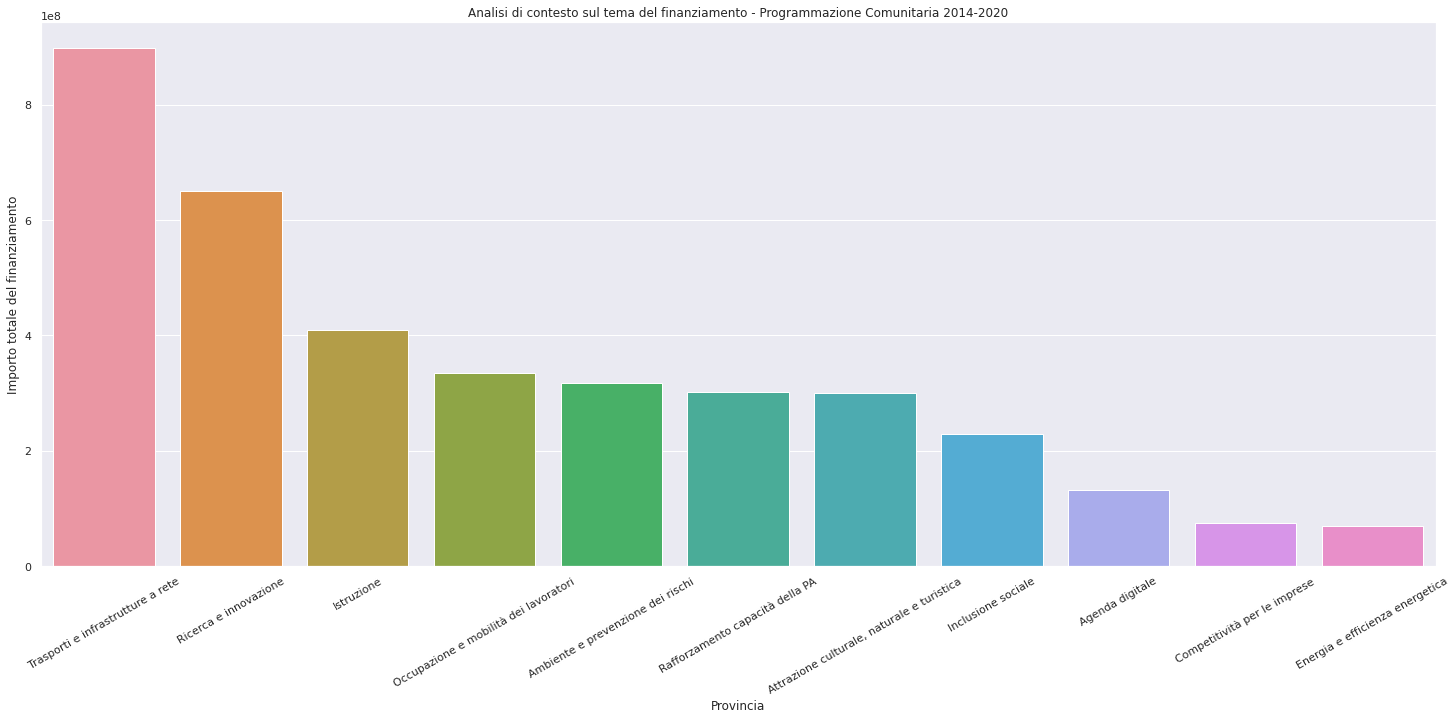

In [ ]:

PfProgetti1420CleanedDescTema=PfProgetti1420Cleaned.groupby('OC_TEMA_SINTETICO', as_index=False).sum().sort_values('FINANZ_TOTALE_PUBBLICO',ascending=False)
PfProgetti1420CleanedDescTema.head(20)
sb.set(rc={'figure.figsize':(25,10)})
grafic=sb.barplot(data=PfProgetti1420CleanedDescTema,x='OC_TEMA_SINTETICO',y='FINANZ_TOTALE_PUBBLICO', ci=False)
pp.title("Analisi di contesto sul tema del finanziamento - Programmazione Comunitaria 2014-2020")
pp.xlabel('Tema sintetico')
pp.ylabel('Importo totale del finanziamento')
grafic.set_xticklabels(grafic.get_xticklabels(),rotation=30)



[Text(0, 0, 'Occupazione e mobilità dei lavoratori'),
 Text(0, 0, 'Istruzione'),
 Text(0, 0, 'Ricerca e innovazione'),
 Text(0, 0, 'Rafforzamento capacità della PA'),
 Text(0, 0, 'Attrazione culturale, naturale e turistica'),
 Text(0, 0, 'Energia e efficienza energetica'),
 Text(0, 0, 'Rinnovamento urbano  e rurale'),
 Text(0, 0, 'Ambiente e prevenzione dei rischi'),
 Text(0, 0, 'Inclusione sociale'),
 Text(0, 0, 'Trasporti e infrastrutture a rete'),
 Text(0, 0, 'Agenda digitale'),
 Text(0, 0, 'Competitività per le imprese')]

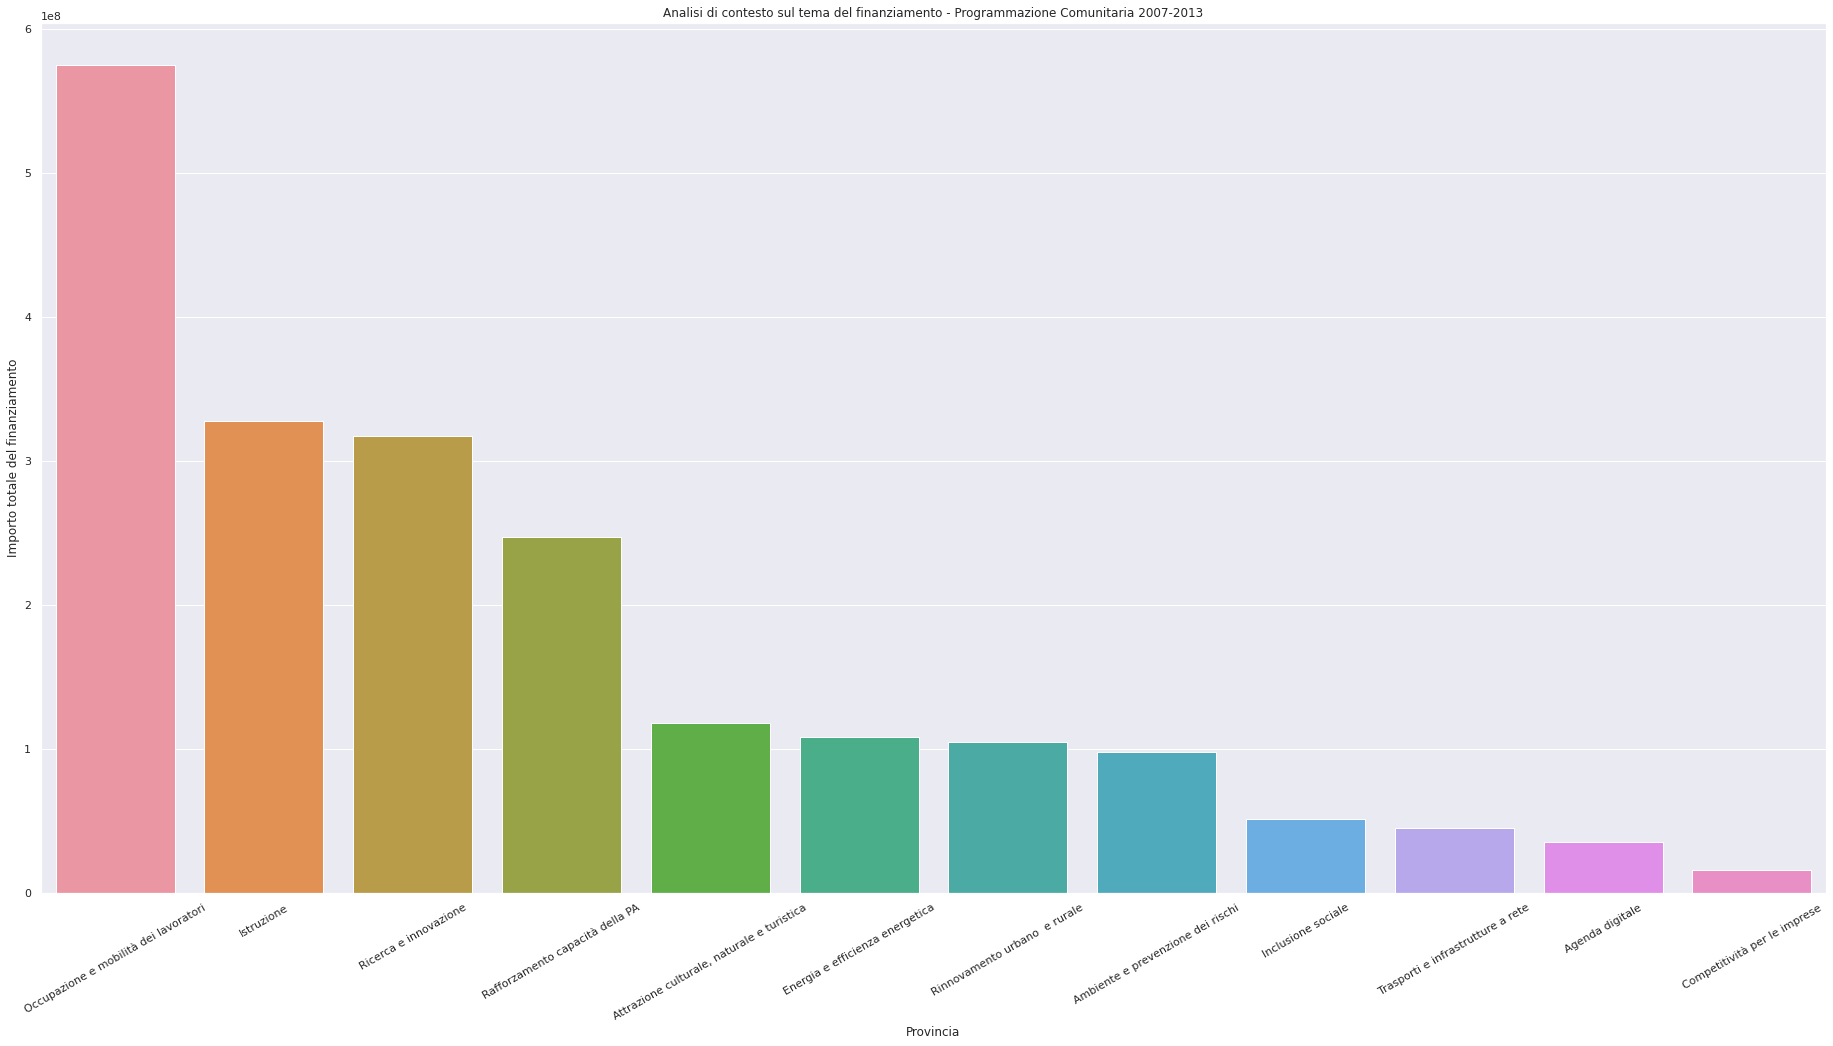

In [ ]:

PfProgetti0713CleanedDescTema=PfProgetti0713Cleaned.groupby('OC_TEMA_SINTETICO', as_index=False).sum().sort_values('FINANZ_TOTALE_PUBBLICO',ascending=False)
PfProgetti0713CleanedDescTema.head(20)
sb.set(rc={'figure.figsize':(32,16)})
grafic=sb.barplot(data=PfProgetti0713CleanedDescTema,x='OC_TEMA_SINTETICO',y='FINANZ_TOTALE_PUBBLICO', ci=False)
pp.title("Analisi di contesto sul tema del finanziamento - Programmazione Comunitaria 2007-2013")
pp.xlabel('Tema Sintetico')
pp.ylabel('Importo totale del finanziamento')
grafic.set_xticklabels(grafic.get_xticklabels(),rotation=30)



L'analisi di contesto è terminata con la tipologia dei progetti presi in esame dove si evince che la categoria "Altro" primeggia. Si potrebbe annotare una criticità su come si stato strutturato il dataset scaricato da OpenCoesione, dove notoriamente la voce "altro" dovrebbe essere minimale rispetto alle altre voci. Per quanto riguarda invece la Programmazione Comunitaria 2007-2013 i Corsi di formazione tolgono il primato proprio alla voce "altro".

[Text(0, 0, 'Altro'),
 Text(0, 0, 'Nuova realizzazione'),
 Text(0, 0, 'Ampliamento o potenziamento'),
 Text(0, 0, 'Assistenza'),
 Text(0, 0, 'Nuova fornitura'),
 Text(0, 0, 'Progetti di ricerca'),
 Text(0, 0, 'Manutenzione straordinaria'),
 Text(0, 0, 'Corsi di formazione'),
 Text(0, 0, "Attivita' di ricerca"),
 Text(0, 0, 'Recupero')]

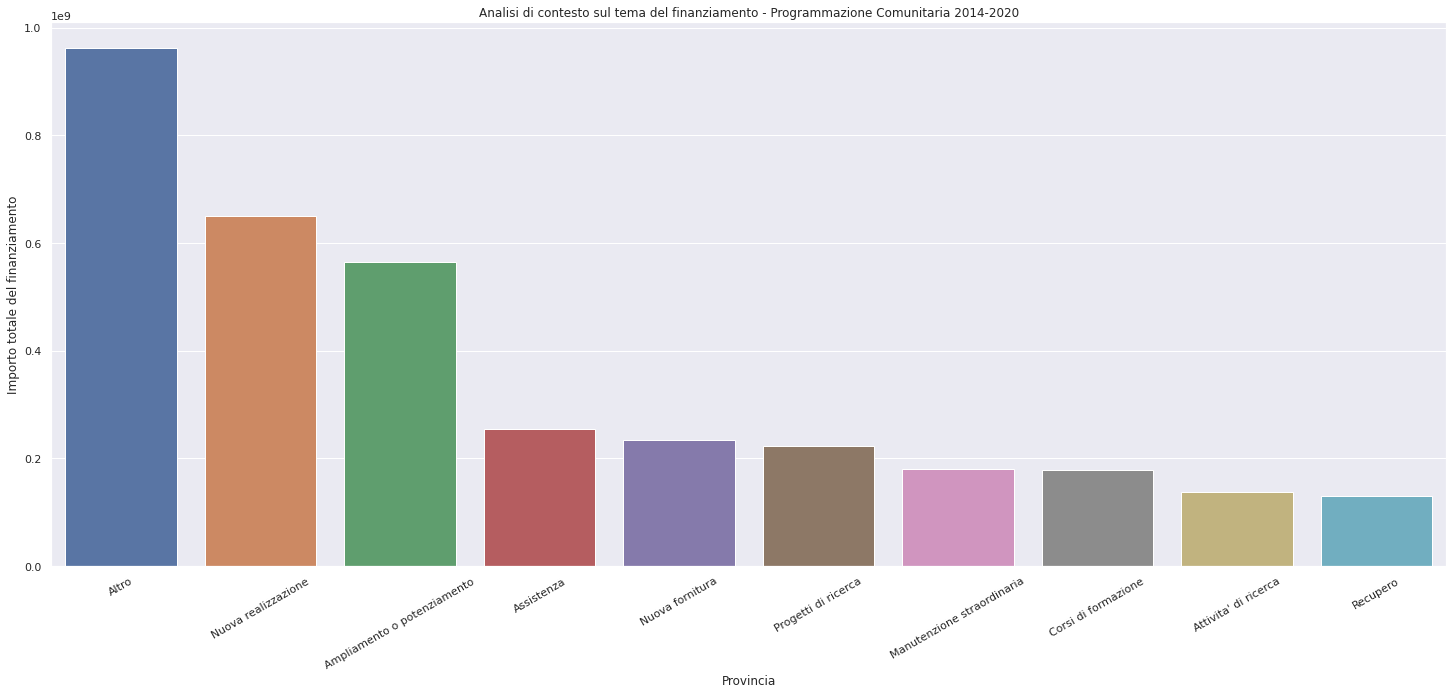

In [ ]:
PfProgetti1420CleanedDescTipologia=PfProgetti1420Cleaned.groupby('CUP_DESCR_TIPOLOGIA',as_index=False).sum().sort_values('FINANZ_TOTALE_PUBBLICO',ascending=False).head(10)
PfProgetti1420CleanedDescTipologia.head(20)
sb.set(rc={'figure.figsize':(25,10)})
grafic=sb.barplot(data=PfProgetti1420CleanedDescTipologia,x='CUP_DESCR_TIPOLOGIA',y='FINANZ_TOTALE_PUBBLICO', ci=False)
pp.title("Analisi di contesto sul tema del finanziamento - Programmazione Comunitaria 2014-2020")
pp.xlabel('Tipologia del finanziamento')
pp.ylabel('Importo totale del finanziamento')
grafic.set_xticklabels(grafic.get_xticklabels(),rotation=30)



[Text(0, 0, 'CORSI DI FORMAZIONE'),
 Text(0, 0, 'ALTRO'),
 Text(0, 0, 'ASSISTENZA'),
 Text(0, 0, "ATTIVITA' DI RICERCA"),
 Text(0, 0, 'NUOVA REALIZZAZIONE'),
 Text(0, 0, 'MANUTENZIONE STRAORDINARIA'),
 Text(0, 0, 'CONSULENZE'),
 Text(0, 0, 'ACQUISTO SERVIZI REALI (INCLUSA FORMAZIONE)'),
 Text(0, 0, 'PROGETTI DI RICERCA'),
 Text(0, 0, "RISTRUTTURAZIONE (PER CAMBIO DI DESTINAZIONE D'USO)")]

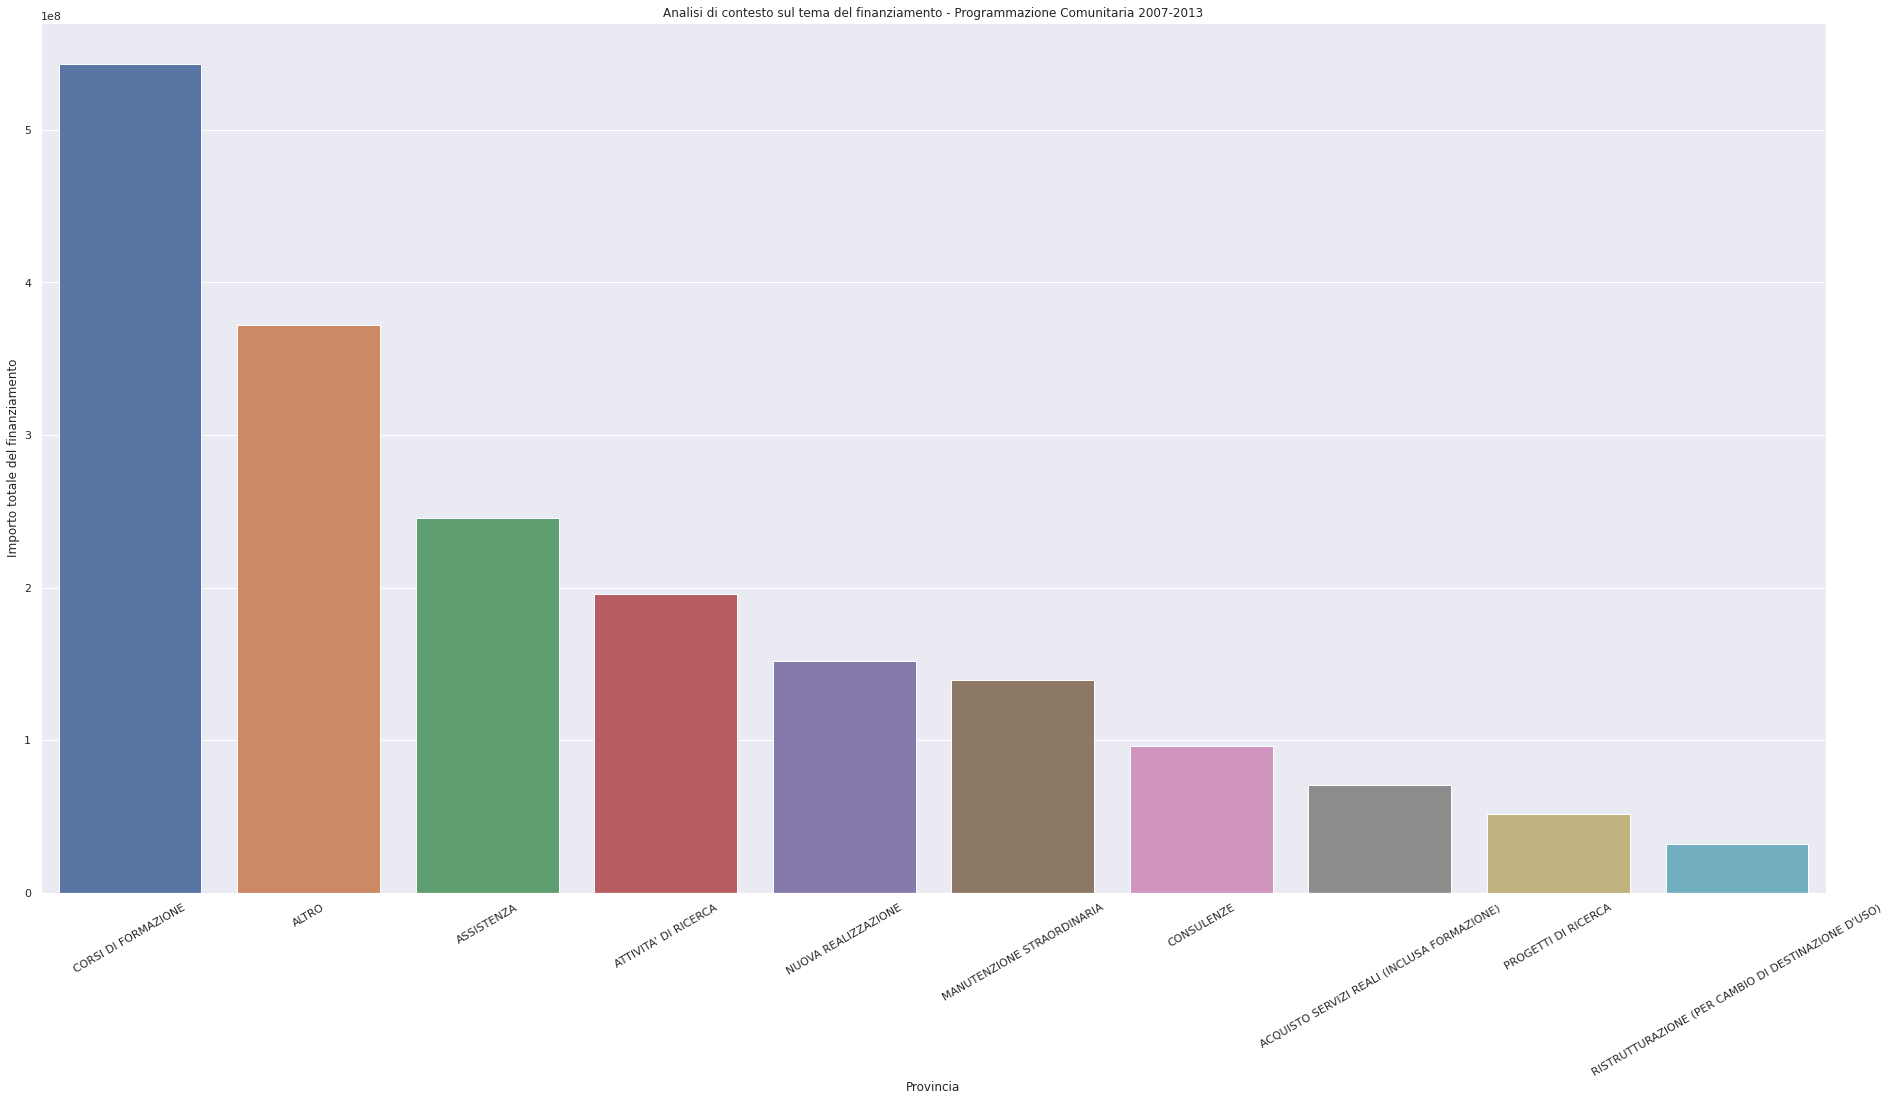

In [ ]:
PfProgetti0713CleanedDescTipologia=PfProgetti0713Cleaned.groupby('CUP_DESCR_TIPOLOGIA',as_index=False).sum().sort_values('FINANZ_TOTALE_PUBBLICO',ascending=False).head(10)
PfProgetti0713CleanedDescTipologia.head(20)
sb.set(rc={'figure.figsize':(32,16)})
grafic=sb.barplot(data=PfProgetti0713CleanedDescTipologia,x='CUP_DESCR_TIPOLOGIA',y='FINANZ_TOTALE_PUBBLICO', ci=False)
pp.title("Analisi di contesto sul tema del finanziamento - Programmazione Comunitaria 2007-2013")
pp.xlabel('Tipologia del finanziamento')
pp.ylabel('Importo totale del finanziamento')
grafic.set_xticklabels(grafic.get_xticklabels(),rotation=30)



Salvataggio dei dataframe in file excel.

In [ ]:
PfProgetti0713Cleaned.to_csv('2017-2013.csv')
PfProgetti0713Cleaned.to_csv('2017-2013.csv')

# **Conclusioni ed osservazioni.**

Concludendo, dall'analisi effettuata, è emerso come Roma sia la provincia dove insistono il maggiore numero di finanziamenti con il maggiore importo totale di quanto finanziato dall'Unione Europea. Tuttavia è Viterbo la provincia che realizza progetti con l'importo medio più elevato.
Restando nell'ambito dell'importo medio è utile notare dall'heatmap mostrato che l'importo medio trovi una maggiore correlazione con l'importo finanziato piuttosto che con la numerosità dei progetti.


Per ciò che concerne l'analisi di contesto ed in particolare per ciò che concerne la natura del finanziamento si può notare come, per la programmazione Comunitaria 2014-2020, l'acquisto o la realizzazione di servizi, insieme alla realizzazione dei lavori pubblici (opere ed impiantistica), siano più costosi rispetto per esempio al mero acquisto di beni.
Inoltre, valutando il periodo storico attraversato nella recessione economica, culminata nel nostro Paese nel 2011, è comprensibile come i finanziamenti venissero dirottati più verso l'occupazione dei lavoratori e la formazione di questi piuttosto che sui trasporti e sulle infrastrutture, che invece hanno il primato nella programmazione più recente. 

  